In [2]:
# auto reload modules
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
#import PES_models as pmodel, PES_models_bonding_features as bond_pmodel
from PES_models_bonding_features import *

### Model 120122 - Bonding feature experiments, 8.1-8.6 of Ulrik


#### Utilities

In [2]:
# transform distance vectors to distance matrices:
def distance_vec_to_mat(R, n_atom):
    '''
    returns distance matrix D_{ij}, symmetric with D_{ii} = 0 forall i
    params:
        - R = vector of distances (R_12, R_13, R_23, ...)
        - n_atom = number of atoms in the molecule
    '''
    upper_idxes = np.triu_indices(n_atom, 1) # get the 
    dist_mat = np.zeros((n_atom, n_atom))
    dist_mat[upper_idxes] = R
    dist_mat = dist_mat + dist_mat.T # no need to consider diagonals because theyre always 0
    return dist_mat

# transform distance matrix into coordinate matrix
def distance_to_coord(dist_vec, N, verbose=False):
    '''
    from https://math.stackexchange.com/questions/156161/finding-the-coordinates-of-points-from-distance-matrix
    convert distance vector r_{ij} to coordinate matrix X := [X_0, X_1, X_2], each element is one point (row wise).
    params: 
        - dist_mat = distance matrix, symmetric with 0 diagonals
    '''
    dist_square = dist_vec**2 #q_{ik}:=r_{ik}^2
    dist_square = distance_vec_to_mat(dist_square, N) # D_{ij} matrix from r_{ij}
    M_mat = np.zeros(dist_square.shape)
    #dist_square = dist_mat**2 # D^2
    vec_sum = np.sum(dist_square, axis = 0) # since it's symmetric, sums for row = col
    M_submat = M_mat[1:, 1:] # submatrix excluding 0s in the first column and row
    upper_idxes = np.triu_indices(M_submat.shape[0], 1)
    row = upper_idxes[0]; col = upper_idxes[1] # upper triangular indexes of the submatrix
    row_actual = row+1; col_actual = col+1 # corresponding (row, col) index matrix of the actual matrix
    for idx in range(row.shape[0]): # fill the off diagonals:
        i = row[idx]; j = col[idx];
        i_actual = row_actual[idx]; j_actual = col_actual[idx]
        M_submat[i][j] = (dist_square[0][j_actual] + dist_square[i_actual][0] - dist_square[i_actual][j_actual])/2
    M_submat = M_submat + M_submat.T
    #print(M_submat)
    # fill the diagonals:
    diag = np.diag_indices(M_submat.shape[0])
    M_submat[diag] = dist_square[0][1:] # M'_i-1i-1 := M_ii = D_1i^2
    # return submat to original:
    M_mat[1:, 1:] = M_submat
    if verbose:
        print("M", M_mat)
    # eigendecomposition:
    eigvals, eigvecs = np.linalg.eigh(M_mat) # symmetric matrix eigendecomposition, uses (eigh)ermitian
    #print(eigvecs @ np.diag(eigvals) @ eigvecs.T) # M = Q*lambda*Q^t
    # replace any very small |x| s.t. x<0 \in R, with 0, if |x|<delta:
    delta = -1e-4 # intuitive near 0 threshold
    eigvals[np.where((eigvals > delta) & (eigvals < 0))] = 0
    if verbose:
        print("eigval =",eigvals)
        print("eigvec =",eigvecs)
    X = eigvecs @ np.diag(np.sqrt(eigvals)) # coordinate matrix, each coordinate = X[i]
    return X

def distance_to_coord_v2(dist_vec, N, verbose=False):
    '''
    convert distance vector r_{ij} to coordinate matrix X := [X_0, X_1, X_2], each element is one point (row wise).
    params: 
        - dist_vec = distance vector, (d_1, d_2, ... )
        - N = number of points, scalar
    '''
    q = dist_vec**2 #q_{ik}:=r_{ik}^2
    Q = distance_vec_to_mat(q, N) # convert to distance matrix
    #print("Q", Q)
    gamma_i = np.sum(Q, axis=1)/N # \gamma_i:=\frac{1}{N}\sum_k q_{ik}:
    #print("gamma_i", gamma_i)
    gamma = np.sum(gamma_i)/(2*N) # \gamma:=\frac{1}{2N}\sum_i \gamma_i
    #print("gamma", gamma)
    G_diag = gamma_i - gamma # G_{ii}=\gamma_i-\gamma
    #print("G_diag", G_diag)
    G = np.diag(G_diag) # G_{ii}=\gamma_i-\gamma
    #print("G", G)
    
    # G_{ik}=\frac12(G_{ii}+G_{kk}-q_{ik}): (probably better to use upper triangular):
    for i in range(N):
        for k in range(N):
            if i != k:
                G[i][k] = (G[i][i] + G[k][k] - Q[i][k])/2
    if verbose:
        print("G:", G)
    eigvals, eigvecs = np.linalg.eigh(G)
    # replace any very small |x| s.t. x<0 \in R, with 0, if |x|<delta:
    delta = -1e-6 # intuitive near 0 threshold
    eigvals[np.where((eigvals > delta) & (eigvals < 0))] = 0
    if verbose:
        print("eigvals =", eigvals)
        print("eigvecs =", eigvecs)
    X = eigvecs @ np.diag(np.sqrt(eigvals))
    return X

#### Transform all H3 data into coordinates

In [138]:
# load data:
f_dir = "data/h3/"
'''
_, _, onlyfiles = next(walk(f_dir))
print(onlyfiles)
lengths = []
for f in onlyfiles[3:]:
    f = open(f_dir+f)
    f_data = json.load(f)
    print(f_data.keys(), len(f_data["data"]), f_data["kind"])
    lengths.append(len(f_data["data"]))
'''
H3_data = np.load("data/h3/h3_data.npy")
R_mat = H3_data[:, :3]
print(H3_data.shape)

(6032, 4)


In [139]:
# v_n function test:
X_list = []
for R in R_mat:
    X_list.append(distance_to_coord_v2(R, 3))
X_list = np.array(X_list)
print("actual data:",X_list.shape)
'''
nan_idx = np.argwhere(np.isnan(X_list))
nan_idx = np.sort(np.array(list(set(nan_idx[:, 0]))))
print("infeasible indexes = ", nan_idx)
# exclude the nan indexes:
print("infeasible data:", nan_idx.shape)
mask = np.ones(X_list.shape[0], dtype=bool)
mask[nan_idx] = False
X_list_cleaned = X_list[mask]
print("feasible data:",X_list_cleaned.shape)
'''

actual data: (6032, 3, 3)


'\nnan_idx = np.argwhere(np.isnan(X_list))\nnan_idx = np.sort(np.array(list(set(nan_idx[:, 0]))))\nprint("infeasible indexes = ", nan_idx)\n# exclude the nan indexes:\nprint("infeasible data:", nan_idx.shape)\nmask = np.ones(X_list.shape[0], dtype=bool)\nmask[nan_idx] = False\nX_list_cleaned = X_list[mask]\nprint("feasible data:",X_list_cleaned.shape)\n'

In [58]:
# each data index test:
idx = 1
print("-=-=-=-=-=-=-=--=-=-=-=-=-=-=-")
print("actual distances: ",R_mat[idx])
print("====== v1 ======")
X = distance_to_coord(R_mat[idx], 3, verbose=True)
print("coordinate result = ",X)
print("distances r_12: ",np.linalg.norm(X[1] - X[2]))
print("====== v2 ======")
X = distance_to_coord_v2(R_mat[idx], 3, verbose=True)
print("coordinate = ",X)
print("distance r_12: ",np.linalg.norm(X[0] - X[1]))

idx = 153
print("\n-=-=-=-=-=-=-=--=-=-=-=-=-=-=-")
print("actual distances: ",R_mat[idx])
print("====== v1 ======")
X = distance_to_coord(R_mat[idx], 3, verbose=True)
print("coordinate result = ",X)
print("distances r_12: ",np.linalg.norm(X[0] - X[1]))
print("====== v2 ======")
X = distance_to_coord_v2(R_mat[idx], 3, verbose=True)
print("coordinate = ",X)
print("distance r_12: ",np.linalg.norm(X[0] - X[1]))

idx = 0
print("\n-=-=-=-=-=-=-=--=-=-=-=-=-=-=-")
print("actual distances: ",R_mat[idx])
print("====== v1 ======")
X = distance_to_coord(R_mat[idx], 3, verbose=True)
print("coordinate result = ",X)
print("distances r_12: ",np.linalg.norm(X[0] - X[1]))
print("====== v2 ======")
X = distance_to_coord_v2(R_mat[idx], 3, verbose=True)
print("coordinate = ",X)
print("distance r_12: ",np.linalg.norm(X[0] - X[1]))


-=-=-=-=-=-=-=--=-=-=-=-=-=-=-
actual distances:  [1.1      1.4      1.402337]
====== v1 ======
M [[0.         0.         0.        ]
 [0.         1.21       0.60172547]
 [0.         0.60172547 1.96      ]]
eigval = [0.         0.87598763 2.29401237]
eigvec = [[ 1.          0.          0.        ]
 [ 0.         -0.87432967  0.4853325 ]
 [ 0.          0.4853325   0.87432967]]
coordinate result =  [[ 0.          0.          0.        ]
 [ 0.         -0.81832195  0.73508447]
 [ 0.          0.45424312  1.32425949]]
distances r_12:  1.402337
====== v2 ======
G: [[ 0.48593899 -0.1179695  -0.3679695 ]
 [-0.1179695   0.48812201 -0.37015252]
 [-0.3679695  -0.37015252  0.73812201]]
eigvals = [0.         0.60499288 1.10719014]
eigvecs = [[-0.57735027  0.70863866 -0.40558343]
 [-0.57735027 -0.70556488 -0.41090736]
 [-0.57735027 -0.00307377  0.8164908 ]]
coordinate =  [[ 0.          0.55118828 -0.42676747]
 [ 0.         -0.54879746 -0.43236948]
 [ 0.         -0.00239082  0.85913695]]
distance r_12:

In [140]:
# save the coordinates and nan_index:
np.save("data/h3/h3_coord", X_list)
#np.save("data/h3/h3_excluded_idx", nan_idx) # everything works now

In [3]:
h3coord = np.load("data/h3/h3_coord.npy")
print(h3coord.shape)

(6032, 3, 3)


#### The fundamentals: 8.1 Bonding features

In [5]:
# bond strength:
def t_R_fun(R, R_up, R_low, e):
    R2 = R**2
    return ((R2 - R_low**2)/(R_up**2 - R2))**e

def s_bond_strength(R, R_up, R_low, t, t0):
    '''
    s_{ij} = s(R_{ij})
    t0 = t_R_fun(Rm, R_up, R_low, e)
    if R_m = R and R_low < R_m < R_up, then bond_strength_s = 0.5
    trainable parameters: (R_low, R_m, R_up)
    '''
    if R < R_low:
        return 1
    elif R_low <= R <= R_up:
        return t0/(t+t0)
    elif R_up < R:
        return 0

# Tchebyshev polynomials functions:
s_prime_fun = lambda s: 2-4*s
def p_tchebyshev_pol(deg, s, s_prime):
    '''
    b_{ijd} = p_d(s_ij), where s_ij := s(R_ij)
    params:
        - deg = degree >= 1
        - s = s_bond_strength(R, R_up, R_low, t, t0)
        - 
    '''
    if deg == 1:
        return s
    elif deg == 2:
        return s*(1-s)
    elif deg == 3: # p_3 = s'p_2
        return s_prime*p_tchebyshev_pol(2, s, s_prime)
    elif deg > 3: # p_{d+1} = s'p_d - p_{d-1}
        return s_prime*p_tchebyshev_pol(deg-1, s, s_prime) - p_tchebyshev_pol(deg-2, s, s_prime)

# reference energy U:
def U_ref_energy(V_fun, R):
    '''
    params:
        - V_fun := function for reference energy
        - R := distance (can be const or vector or matrix)
    '''
    return V_fun(R)

# coordination vector Y_d[i]:
def gen_bijd_mat(R_mat, max_deg, n_atom, R_up, R_m, R_low, e):
    '''
    b_ijd matrix generator \in R^{d x degree of freedom of atom i},
    b_ijd_mat, e.g, molecule with 3 atom := 
            [
                [b_{121}, b_{131}, b_{231},... ]
                [b_{122}, b_{132}, b_{232},... ]
                [b_{123}, ...] ...
            ] 
            \in R^{d x degree of freedom (DoF) of atom i}, np.array(dtype=float)
    params:
        - R_mat := [
                    [R_12, R_13, R_14, R_23, ...] := idx = 0
                    [R_12, R_13, ....] := idx = 1
                    [... ] ...
                ] \in R^{n x DoF of mol}
        - max_deg = maximum degree, d = 1,2,...,max_deg
        - n_atom = num atoms in the molecular system, e.g.: H3 -> n = 3
        - R_up for t and s(R), \in R
        - R_m for t and s(R), \in R
        - R_low for t and s(R), \in R
        - e for t and s(R), \in R
    '''
    # R_submat = R_mat[:, :n_atom-1] # all distances of atom i (len(R) x n_atom-1)
    t0 = t_R_fun(R_m, R_up, R_low, e) # const 
    t_mat = t_R_fun(R_mat, R_up, R_low, e) # matrix (len(R) x n_atom)
    s_mat = np.zeros(R_mat.shape) # matrix (len(R) x n_atom)
    # need to check the each element one by one due to bool op:
    for i in range(R_mat.shape[0]):
        for j in range(R_mat.shape[1]):
            s_mat[i][j] = s_bond_strength(R_mat[i][j], R_up, R_low, t_mat[i][j], t0)
    #print(s_mat)
    s_prime_mat = s_prime_fun(s_mat)
    b_ijd_mat = np.array([p_tchebyshev_pol(deg, s_mat, s_prime_mat) for deg in range(1, max_deg+1)]) # tensor (max_deg, len(R), n_atom)
    return b_ijd_mat
        
def atom_indexer(num_atom):
    '''
    generates array of coordination indexes for Y[i] vector, which depends on num_atom, e.g.:
    num_atom = 3:  [[1,2],[1,3],[2,3]] - 1 (due to start at 0)
                     b_1j  b_2j b_3j
    num_atom = 4: [[1,2,3],[1,4,5],[2,4,6],[3,5,6]] - 1
                    b_1j     b_2j   b_3j     b_4j
    '''
    init_idx = list(range(num_atom-1, 0, -1))
    group_idx = []
    start = 0
    for idx in init_idx: # enumerate the indexes:
        list_index = list(range(start, idx+start))
        group_idx.append(list_index)
        start += idx
    coord_idx = [] # coordination indexes 
    for i in range(num_atom): # starts from 0 not 1!
        coord = []
        if i==0:
            coord = group_idx[i]
            coord_idx.append(coord)
        elif i==num_atom-1:
            enumerator = list(range(i-1, -1, -1))
            #print(i, enumerator)
            counter = 0
            for num in enumerator:
                coord.append(group_idx[counter][num])
                counter += 1
            coord_idx.append(coord)
        else:
            enumerator = list(range(i-1, -1, -1))
            #print(i, enumerator)
            counter = 0
            for num in enumerator:
                coord.append(group_idx[counter][num])
                counter += 1
            coord.extend(group_idx[counter])
            coord_idx.append(coord)
    return np.array(coord_idx)

       
def Y_coord_mat(b_ijd_mat, coord_idx_mat):
    '''
    returns Y := (Y[1], Y[2], ... Y[num_atom]), where Y[i] := (Y_1[i], Y_2[i], ... Y_max_d[i]),
    where Y_d[i] := \Sum_{j\neqi}b_{ijd} || shape = (num_atom, d, num_data)
    params:
        - b_ijd_mat := 
            [
                [b_{121}, b_{131}, ... ]
                [b_{122}, b_{132}, ... ]
                [b_{123}, ...] ...
            ] 
            \in R^{d x num_data x degree of freedom (DoF) of atom i}, np.array(dtype=float)
        - coord_idx_mat := list of indexes for Y[i] forall i, e.g.:
        num_atom = 4: [[1,2,3],[1,4,5],[2,4,6],[3,5,6]] - 1
                       b_1j     b_2j   b_3j     b_4j
    '''
    num_atom = coord_idx_mat.shape[0]; num_data = b_ijd_mat.shape[1]; max_d = b_ijd_mat.shape[0]
    Y = np.zeros((num_atom, max_d, num_data)) # a tensor (list of Y[i])
    # loop per atom i:
    for i, coord in enumerate(coord_idx_mat):
        Y[i] = np.sum(b_ijd_mat[:, :, coord], axis=2) # sum b_(i)jd
    return Y

# Orientation vector:
def delta_coord_matrix(X_mat):
    '''
    computes and arranges the (x_j - x_i) coodinates in such a way that the indexing is compatible with Y, r, and G,
    returns delta_mat, shape = (num_data, DoF, num_basis)
    params:
        - X_mat, list of coordinates matrix, shape = (num_data, num_atoms, num_elem)
    '''
    num_data = X_mat.shape[0]; num_atoms = X_mat.shape[1]; num_elem = X_mat.shape[2]
    n = num_atoms
    dof = int(n*(n-1)/2) # degree of freedom
    delta_coord_mat = np.zeros((num_data, dof, num_elem))
    for d in range(num_data):
        # for each data, loop the atoms:
        dof_counter = 0
        for i in range(num_atoms):
            for j in range(num_atoms):
                if i < j:
                    delta_coord_mat[d][dof_counter] = X_mat[d][j] - X_mat[d][i]
                    dof_counter += 1
    return delta_coord_mat
        
        
def r_orient_vec(b_ijd_mat, delta_coord_matrix, coord_idx_mat):
    '''
    computes the r := (r[1], r[2],...), where r[i] := r_1[i], r_2[i],... ;
    where r_d[i] \in R^3 = sum(b_ij*delta_ij) for i!=j, i,j = 1,2,...;
    shape = (num_atom, d, num_data, num_elem)
    params:
        - b_ijd_mat, bond strength matrix, shape = (d, num_data, dof)
        - delta_coord_matrix, matrix containing (x_j - x_i), shape = (num_data, dof, num_elem)
    '''
    num_atom = coord_idx_mat.shape[0]; max_d = b_ijd_mat.shape[0]; num_data = delta_coord_matrix.shape[0]; 
    dof = delta_coord_matrix.shape[1]; num_elem = delta_coord_matrix.shape[2];
    # compute the matmul between b and delta:
    b_mult_delta = np.zeros((max_d, num_data, dof, num_elem)) # b*delta, shape = (d, num_data, dof, num_elem)
    # naive way:
    for d in range(max_d):  # for each dimension:
        for dat in range(num_data): # for each data:
            for deg in range(dof): # for each degree of freedom:
                b_mult_delta[d][dat][deg] = b_ijd_mat[d][dat][deg]*delta_coord_matrix[dat][deg] # b_ijd * delta_ji
    #print(b_mult_delta)
    #print(b_mult_delta.shape)
    # compute the sum, same way with Y:
    r = np.zeros((num_atom, max_d, num_data, num_elem))
    for i, coord in enumerate(coord_idx_mat):
        r[i] = np.sum(b_mult_delta[:, :, coord], axis = 2)
    return r



# Gram matrix:
def atom_indexer_G_mat(coord_idx_mat):
    '''
    # for non orientation vector version
    generate the indexes for G matrix formula, 
    depends heavily on the coord_idx_mat,
    e.g:
    [[0, 1],[0, 2],[0, 3],[1, 2],[1, 3],[2, 3]], -> i=1
    [[0, 4],[0, 5],[0, 6],[4, 5],[4, 6],[5, 6]], -> i=2
    ...
    \in R^(num_atom x ^nC_r x 2), n = coord_idx_mat.shape(1), r = 2
    
    params:
        - coord_idx_mat = matrix for indexing, shape = (DoF, 2)
    '''
    G_idx_mat = np.array([list(itertools.combinations(coord, 2)) for coord in coord_idx_mat])
    return G_idx_mat
     


def G_gram_mat(r_mat):
    '''
    makes use of orientation vectors !!
    returns Gramian matrix, G[i]_d1d2 = r_d1[i] \dot r_d2[i]... # Pg 60 of Ulrik
    shape = (num_atom, max_d, max_d, num_data)
    params:
        - r_mat = list of orientation vectors, shape = (num_atom, max_d, num_data, num_elem)
    '''
    num_atom = r_mat.shape[0]; max_d = r_mat.shape[1]; num_data = r_mat.shape[2]; num_elem = r_mat.shape[3]
    G_mat = np.zeros((num_atom, max_d, max_d, num_data))
    for i in range(num_atom): # each atom:
        for d1 in range(max_d): # each dim1:
            for d2 in range(max_d): # each dim2:
                '''
                print(i, d1, d2)
                print(r_mat[i][d1])
                print(r_mat[i][d2])
                print(np.sum(r_mat[i][d1]*r_mat[i][d2], axis=-1))
                '''
                G_mat[i] = np.sum(r_mat[i][d1]*r_mat[i][d2], axis=-1) # r_d1[i]*r_d2[i] 
    return G_mat


# Neigborhood matrices Theta:



#### 8.2 Bonding potential with trainable reference pairpot

In [5]:
# will be changed to np.where version to allow vectorization if possible:
def V_ref_pairpot(R, C, R_h, R_C, R_0, g):
    '''
    returns energy, reference potential
    params:
        - R = distance, must be a scalar (due to comparison check)
        - C, R_h, R_C, R_0, g; scalar constants
        
    '''
    if R <= R_h:
        return np.inf
    elif R_h < R <= R_C:
        R2 = R**2
        return -C*(R_C**2 - R2)**g*( (R2 - R_0**2)/(R2 - R_h**2) )
    else:
        return 0

    
def U_ref_energy(R_mat, C, R_h, R_C, R_0, g, indexer):
    '''
    computes the reference energy matrix, U[i] = \sum V_ij, shape = (num_atom, num_data)
    parameters:
        - R_mat = distance matrix, shape = (num_data, dof)
        - C, R_h, R_C, R_0, g = scalar constants
        - indexer = indexer matrix, shape = (num_atom, num_atom-1)
    '''
    num_data = R_mat.shape[0]; dof = R_mat.shape[1]; num_atom = indexer.shape[0]
    Vref = np.zeros((num_data, dof))
    U = np.zeros((num_atom, num_data))
    # transposed order:
    for i in range(num_data):
        for j in range(dof):
            Vref[i][j] = V_ref_pairpot(R_mat[i][j], C, R_h, R_C, R_0, g)
    #print(Vref)
    for i, coord in enumerate(indexer):
        U[i] = np.sum(Vref[:, coord], axis=1)
    return U
    
    
# basis functions phi:
# max degree = 5
def phi_fun(U, Y, G):
    '''
    constructs matrix containing basis functions phi, shape = (num_atom, num_basis, num_data), # Table 11 of Ulrik
    params:
        - U = reference pair potential energy, shape = (num_atom, num_data)
        - Y = matrix of coordination vectors, shape = (num_atom, max_d, num_data)
        - G = Gram matrix, shape = (num_atom, max_d, max_d, num_data)
    '''
    num_atom = U.shape[0]; num_data = U.shape[1]; num_basis = 59; #59 basis
    phi = np.zeros((num_atom, num_basis, num_data))
    #print(phi.shape)
    # degree 1:
    phi[:, 0] = U;
    phi[:, 1] = Y[:, 0];
    
    # degree 2:
    phi[:, 2] = U*Y[:, 0];
    phi[:, 3] = Y[:, 0]**2; phi[:, 4] = Y[:, 1]; phi[:, 5] = G[:, 0,0];
    
    # degree 3:
    phi[:, 6] = U*phi[:, 3]; phi[:, 7] = U*Y[:, 1]; phi[:, 8] = U*G[:, 0, 0];
    phi[:, 9] = phi[:, 3]*Y[:, 0]; phi[:, 10] = Y[:, 0]*Y[:, 1]; phi[:, 11] = Y[:, 2]; phi[:, 12] = G[:, 0, 0]*Y[:, 0]; phi[:, 13] = G[:, 0, 1];
    
    # degree 4 [14:30]:
    phi[:, 14] = U*phi[:, 9];
    phi[:, 15] = U*Y[:, 0]*Y[:, 1];
    phi[:, 16] = U*Y[:, 2];
    phi[:, 17] = U*G[:, 0,0]*Y[:, 0];
    phi[:, 18] = U*G[:, 0,1];
    phi[:, 19] = phi[:, 9]*Y[:, 0]; #Y_1^4
    phi[:, 20] = phi[:, 3]*Y[:, 1]; #Y_1^2Y_2
    phi[:, 21] = Y[:, 0]*Y[:, 2];
    phi[:, 22] = Y[:, 1]**2; #Y_2^2
    phi[:, 23] = Y[:, 3];
    phi[:, 24] = G[:, 0,0]*phi[:, 3];
    phi[:, 25] = G[:, 0,0]*Y[:, 1];
    phi[:, 26] = G[:, 0,0]**2;
    phi[:, 27] = G[:, 0,1]*Y[:, 0];
    phi[:, 28] = G[:, 0,2];
    phi[:, 29] = G[:, 1,1];
    
    # degree 5 [30:59]:
    phi[:, 30] = U*phi[:, 19];
    phi[:, 31] = U*phi[:, 3]*Y[:, 1];
    phi[:, 32] = U*phi[:, 3]*G[:, 0,0];
    phi[:, 33] = U*Y[:, 0]*Y[:, 2];
    phi[:, 34] = U*phi[:, 27];
    phi[:, 35] = U*phi[:, 22];
    phi[:, 36] = U*phi[:, 25];
    phi[:, 37] = U*Y[:, 3];
    phi[:, 38] = U*phi[:, 26];
    phi[:, 39] = U*G[:, 0,2];
    phi[:, 40] = U*G[:, 1,1];
    
    phi[:, 41] = phi[:, 19]*Y[:, 0]; # Y_1^5
    phi[:, 42] = phi[:, 9]*phi[:, 3];
    phi[:, 43] = phi[:, 9]*G[:, 0,0];
    phi[:, 44] = phi[:, 3]*Y[:, 2];
    phi[:, 45] = phi[:, 3]*G[:, 0,1];
    phi[:, 46] = Y[:, 0]*phi[:, 22];
    phi[:, 47] = phi[:, 10]*G[:, 0,0];
    phi[:, 48] = Y[:, 0]*Y[:, 3];
    phi[:, 49] = phi[:, 12]*G[:, 0,0];
    phi[:, 50] = Y[:, 0]*G[:, 0,2];
    
    phi[:, 51] = Y[:, 0]*G[:, 1,1]
    phi[:, 52] = Y[:, 1]*Y[:, 2]
    phi[:, 53] = Y[:, 1]*G[:, 0,1]
    phi[:, 54] = Y[:, 2]*G[:, 0,0]
    phi[:, 55] = Y[:, 4]
    phi[:, 56] = G[:, 0,0]*G[:, 0,1]
    phi[:, 57] = G[:, 0,3]
    phi[:, 58] = G[:, 1,2]

    return phi

# energy models:
def A_i_term(A1, A2, phi, i):
    '''
    returns partial energy model term A[i], shape = num_data. # page 61 of Ulrik
    params:
        - phi = matrix of basis functions, shape = (num_atom, num_basis, num_data)
        - A1 = vector of tuning parameters, shape = num_basis
        - A2 = vector of tuning parameters, shape = num_basis
        - i = atom index
    '''
    num_basis = phi.shape[1]
    numer = 0; denom = 0
    for k in range(num_basis):
        numer += A1[k]*phi[i,k] #scalar*vector
        denom += A2[k]*phi[i,k] #scalar*vector
    denom = denom**2 + 1
    A_i = numer/denom
    return A_i

def T0_i_term(T1, T2, phi, i):
    '''
    returns partial energy model term T0[i] \in R for B and C. shape = num_data
    params:
        - phi = matrix of basis functions, shape = (num_atom, num_basis, num_data)
        - T1 = vector of tuning parameters, shape = num_basis
        - T2 = vector of tuning parameters, shape = num_basis
        - i = atom index
    '''
    num_basis = phi.shape[1]
    numer = 0; denom = 0
    for k in range(num_basis):
        numer += T1[k]*phi[i,k] #scalar*vector
        denom += T2[k]*phi[i,k] #scalar*vector
    numer = numer**2
    denom = denom**2 + 1
    T_i = numer/denom
    return T_i

def epsilon_i_term(A_i, B_i, C_i):
    '''
    returns energy model \epsilon_i, shape = (num_data)
    params:
        - A_i = partial term, shape = num_data
        - B_i = partial term, shape = num_data
        - C_i = partial term, shape = num_data
    '''
    epsilon_i = A_i - np.sqrt(B_i + C_i)
    #print(A_i, B_i, C_i, epsilon_i)
    return epsilon_i

def epsilon_wrapper(phi, A1, A2, B1, B2, C1, C2):
    '''
    computes the \epsilon_0 in eq.(62) from all of the partial energy terms # pg 61
    params:
        - phi = matrix of basis functions, shape = (num_atom, num_basis, num_data)
        - A1, A2, B1, B2, C1, C2 = vectors of tuning parameters, shape = num_basis
    '''
    num_atom = phi.shape[0]
    
    A = np.array([A_i_term(A1, A2, phi, i) for i in range(num_atom)]) # A term, shape = (num_atom, num_data)
    B = np.array([T0_i_term(B1, B2, phi, i) for i in range(num_atom)]) # B term
    C = np.array([T0_i_term(C1, C2, phi, i) for i in range(num_atom)]) # C term
    
    
    epsilon = 0
    for i in range(num_atom):
        epsilon += epsilon_i_term(A[i], B[i], C[i]) # \sum \epsilon_0[i]
    return epsilon

### Objective fun

In [190]:
59*6 + 7 # num of params

361

In [6]:
# tuning params: C, R_h, R_low, R_0, R_m, R_up, R_C = scalar; A1, A2, B1, B2, C1, C2 = num_basis
def f_pot_bond(C, R_h, R_low, R_0, R_m, R_up, R_C, A1, A2, B1, B2, C1, C2, R, X, indexer, num_atom, max_deg, e, g=6):
    '''
    computes the energy, shape = (num_data)
    params: 
        - C, R_h, R_low, R_0, R_m, R_up, R_C; scalar || TUNING PARAMS
        - A1, A2, B1, B2, C1, C2; shape = num_basis || TUNING PARAMS
        - R: distance matrix, shape = (num_data, dof)
        - X: coordinate matrix, shape = (num_data, num_atom, 3)
        - indexer = matrix of atomic indexer, shape = (num_atom, num_atom-1)
        - num_atom: number of atoms in molecule, scalar
        - max_deg: maximum degree 
        - e: hyperparameter for bond strength, scalar > 2
        - g: hyperparameter for U, scalar (default=6)
    '''
    # compute U basis, contains tuning params (C, R_h, R_C, R_0):
    U = U_ref_energy(R, C, R_h, R_C, R_0, g, indexer)
    #print('U')
    #print(U)
    #
    # compute Y basis, contains tuning params (R_up, R_m, R_low):
    b = gen_bijd_mat(R, max_deg, num_atom, R_up, R_m, R_low, e)
    Y = Y_coord_mat(b, indexer)
    #print("b")
    #print(b)
    
    # compute G basis:
    delta = delta_coord_matrix(X)
    r = r_orient_vec(b, delta, indexer)
    G = G_gram_mat(r)
    
    # compute phi matrix:
    phi = phi_fun(U, Y, G)
    #print('phi')
    #print(phi)
    
    # compute the energy, contains tuning params (A1, A2, B1, B2, C1, C2):
    V = epsilon_wrapper(phi, A1, A2, B1, B2, C1, C2)
    return V

def f_pot_bond_wrapper(coeffs, *args):
    '''
    wrapper for f_pot_bond, unrolls tuning coeffs
    params:
        - coeffs: tuning coeffs in this order:
            - C, R_h, R_low, R_0, R_m, R_up, R_C; scalar
            - theta: matrix containing (A1, A2, B1, B2, C1, C2), shape = (6, num_basis)
        - *args: function arguments in this order:
            - num_basis: number of basis (column) in the phi matrix
            - R: distance matrix, shape = (num_data, dof)
            - X: coordinate matrix, shape = (num_data, num_atom, 3)
            - indexer = matrix of atomic indexer, shape = (num_atom, num_atom-1)
            - num_atom: number of atoms in molecule, scalar
            - max_deg: maximum degree 
            - e: hyperparameter for bond strength, scalar > 2
            - g: hyperparameter for U, scalar (default=6)
    '''
    # unroll args first:
    num_basis = args[0]
    R = args[1]
    X = args[2]
    indexer = args[3]
    num_atom = args[4]
    max_deg = args[5]
    e = args[6]
    g = args[7]
    
    # unroll coefficients:
    C = coeffs[0]; R_h = coeffs[1]; R_low = coeffs[2]; R_0 = coeffs[3]; R_m = coeffs[4]; R_up = coeffs[5]; R_C = coeffs[6];
    A1 = coeffs[7: num_basis+7]
    A2 = coeffs[num_basis+7: 2*num_basis+7]
    B1 = coeffs[2*num_basis+7: 3*num_basis+7]
    B2 = coeffs[3*num_basis+7: 4*num_basis+7]
    C1 = coeffs[4*num_basis+7: 5*num_basis+7]
    C2 = coeffs[5*num_basis+7: 6*num_basis+7]
    
    # compute energy from model:
    V_pred = f_pot_bond(C, R_h, R_low, R_0, R_m, R_up, R_C, A1, A2, B1, B2, C1, C2, 
                        R, X, indexer, num_atom, max_deg, e, g)
    
    return V_pred


def f_obj_leastsquares(coeffs, *args):
    '''
    objective function in the form of residuals Y - Y_pred, shape = len(Y)
    params:
        - coeffs: array of coefficients, shape = len(coeffs)
        - *args:
            - F: evaluation function, F(.)
            - Y: actual data, shape = len(Y)
            - args[2:]: the rest of the arguments for F(.)
    '''
    # unroll variables:
    F = args[0]
    Y = args[1]
    Y_pred = F(coeffs, *args[2:])
    
    # residuals:
    res = Y - Y_pred

    #print(res)
    
    return res

In [26]:
# multistart
def multistart_method(F_obj, F_eval, Y_test, 
                      C_lb = -5., C_ub = 5., C_size = 100, method = "trf",
                      resets = 5, inner_loop_mode = False, inner_loop = 5, constant = 0.1, verbose=False,
                      args_obj = None, args_eval = None, args_minimize = None
                     ):
    '''
    multi-start method revisited, same ol' (hopefully more modular/general), returns the RMSE and tuning coeff
    '''
    min_RMSE = np.inf; min_C = None
    # non inner loop mode:
    for i in range(resets):
        # re-init C:
        C = np.random.uniform(C_lb, C_ub, C_size)
        # optimize:
        res = minimize(F_obj, C, args=args_obj, method=method) #scipy's minimizer 
        Y_pred = F_eval(res.x, *args_eval)
        rmse = pmodel.RMSE(Y_test, Y_pred)
        if verbose:
            print(i, rmse)
        if rmse < min_RMSE:
            min_RMSE = rmse; min_C = res.x
    # if inner_loop_mode:
    
    return min_RMSE, min_C
    


In [28]:
# multistart test:
def fun_rosenbrock(x, args): # argmin f(x) = [1.0, 1.0]
    y = args[0] #nothing just for test
    print(*args)
    args[0] = 1234
    print(*args)
    #yy = x + y
    return np.array([10 * (x[1] - x[0]**2), (1 - x[0])])

fun_rosenbrock([1,1], (1,2,3,4))

1 2 3 4


TypeError: 'tuple' object does not support item assignment

In [32]:
for i in range(5):
    print(np.random.uniform(-10, 10, 5))

[ 3.59695903 -4.87440101 -3.0483757  -9.8117446  -2.83332435]
[ 8.98188363 -5.64201982 -3.61217267  8.35544772 -9.36192667]
[-8.69830926  2.59657998  7.47626887 -9.82568535  4.93154474]
[ 6.25682342 -8.48565108  3.12910669  0.185244   -0.40233217]
[ 9.1114829  -9.99975933 -5.06042598  4.24465356 -3.508359  ]


In [7]:
# orient vec test:
#deg = 3; data = 5
numatom = 4; deg = 5; data = 10
b = np.array([1,2,3,4,5,6])
b = b[np.newaxis, :]
b = np.repeat(b, data, axis = 0)
for i in range(b.shape[0]):
    b[i] += i
b = b[np.newaxis, :]
b = np.repeat(b, deg, axis=0)
for i in range(b.shape[0]):
    b[i] *= i
    if i % 2 == 0:
        b[i] *= -1
#b[2] += 1
print("b = ")
print(b, b.shape)
delta = np.array([[1,1,1],[2,2,2],[3,3,3],[4,4,4],[5,5,5],[6,6,6]])
delta = delta[np.newaxis, :]
delta = np.repeat(delta, data, axis=0)
print("delta = ")
print(delta, delta.shape)
indexer = atom_indexer(numatom)
print("indexer = ")
print(indexer, indexer.shape)
print("Y")
Y = Y_coord_mat(b, indexer)
print(Y, Y.shape)
print("b*delta = ")
r = r_orient_vec(b, delta, indexer)
print("r = ")
print(r, r.shape)

# Gram matrix test:
G = G_gram_mat(r)
print("G = ")
print(G)
print(G.shape)

b = 
[[[  0   0   0   0   0   0]
  [  0   0   0   0   0   0]
  [  0   0   0   0   0   0]
  [  0   0   0   0   0   0]
  [  0   0   0   0   0   0]
  [  0   0   0   0   0   0]
  [  0   0   0   0   0   0]
  [  0   0   0   0   0   0]
  [  0   0   0   0   0   0]
  [  0   0   0   0   0   0]]

 [[  1   2   3   4   5   6]
  [  2   3   4   5   6   7]
  [  3   4   5   6   7   8]
  [  4   5   6   7   8   9]
  [  5   6   7   8   9  10]
  [  6   7   8   9  10  11]
  [  7   8   9  10  11  12]
  [  8   9  10  11  12  13]
  [  9  10  11  12  13  14]
  [ 10  11  12  13  14  15]]

 [[ -2  -4  -6  -8 -10 -12]
  [ -4  -6  -8 -10 -12 -14]
  [ -6  -8 -10 -12 -14 -16]
  [ -8 -10 -12 -14 -16 -18]
  [-10 -12 -14 -16 -18 -20]
  [-12 -14 -16 -18 -20 -22]
  [-14 -16 -18 -20 -22 -24]
  [-16 -18 -20 -22 -24 -26]
  [-18 -20 -22 -24 -26 -28]
  [-20 -22 -24 -26 -28 -30]]

 [[  3   6   9  12  15  18]
  [  6   9  12  15  18  21]
  [  9  12  15  18  21  24]
  [ 12  15  18  21  24  27]
  [ 15  18  21  24  27  30]
  [ 18  2

In [181]:
# reshape b into (num_data, d, dof) test:
print(b.shape)
b_reshape = np.transpose(b, (1, 0, 2))
print(b_reshape, b_reshape.shape)

(5, 10, 6)
[[[  0   0   0   0   0   0]
  [  1   2   3   4   5   6]
  [ -2  -4  -6  -8 -10 -12]
  [  3   6   9  12  15  18]
  [ -4  -8 -12 -16 -20 -24]]

 [[  0   0   0   0   0   0]
  [  2   3   4   5   6   7]
  [ -4  -6  -8 -10 -12 -14]
  [  6   9  12  15  18  21]
  [ -8 -12 -16 -20 -24 -28]]

 [[  0   0   0   0   0   0]
  [  3   4   5   6   7   8]
  [ -6  -8 -10 -12 -14 -16]
  [  9  12  15  18  21  24]
  [-12 -16 -20 -24 -28 -32]]

 [[  0   0   0   0   0   0]
  [  4   5   6   7   8   9]
  [ -8 -10 -12 -14 -16 -18]
  [ 12  15  18  21  24  27]
  [-16 -20 -24 -28 -32 -36]]

 [[  0   0   0   0   0   0]
  [  5   6   7   8   9  10]
  [-10 -12 -14 -16 -18 -20]
  [ 15  18  21  24  27  30]
  [-20 -24 -28 -32 -36 -40]]

 [[  0   0   0   0   0   0]
  [  6   7   8   9  10  11]
  [-12 -14 -16 -18 -20 -22]
  [ 18  21  24  27  30  33]
  [-24 -28 -32 -36 -40 -44]]

 [[  0   0   0   0   0   0]
  [  7   8   9  10  11  12]
  [-14 -16 -18 -20 -22 -24]
  [ 21  24  27  30  33  36]
  [-28 -32 -36 -40 -44 -4

In [119]:
# ref pairpot test:
R = np.array([1,2,3, 4, 5, 6])
R = R[np.newaxis, :]
R = np.repeat(R, data, axis = 0)
print(R, R.shape)
indexer = atom_indexer(num_atom)
print(indexer, indexer.shape)
U = U_ref_energy(R, 1, 0, 4, 1, 1, indexer) #R_mat, C, R_h, R_C, R_0, g, indexer
print(U, U.shape)

[[1 2 3 4 5 6]
 [1 2 3 4 5 6]
 [1 2 3 4 5 6]
 [1 2 3 4 5 6]
 [1 2 3 4 5 6]
 [1 2 3 4 5 6]
 [1 2 3 4 5 6]
 [1 2 3 4 5 6]
 [1 2 3 4 5 6]
 [1 2 3 4 5 6]] (10, 6)
[[0 1 2]
 [0 3 4]
 [1 3 5]
 [2 4 5]] (4, 3)
[[-0.         -9.         -6.22222222  0.          0.          0.        ]
 [-0.         -9.         -6.22222222  0.          0.          0.        ]
 [-0.         -9.         -6.22222222  0.          0.          0.        ]
 [-0.         -9.         -6.22222222  0.          0.          0.        ]
 [-0.         -9.         -6.22222222  0.          0.          0.        ]
 [-0.         -9.         -6.22222222  0.          0.          0.        ]
 [-0.         -9.         -6.22222222  0.          0.          0.        ]
 [-0.         -9.         -6.22222222  0.          0.          0.        ]
 [-0.         -9.         -6.22222222  0.          0.          0.        ]
 [-0.         -9.         -6.22222222  0.          0.          0.        ]]
[[-15.22222222 -15.22222222 -15.22222222 -15.2

In [125]:
# basis function test:
print('U.shape', U.shape)
print('Y.shape', Y.shape)
print('G.shape', G.shape)
phi = phi_fun(U, Y, G)
print(phi, phi.shape)

U.shape (4, 10)
Y.shape (4, 5, 10)
G.shape (4, 5, 5, 10)
(4, 59, 10)
[[[-1.52222222e+01 -1.52222222e+01 -1.52222222e+01 ... -1.52222222e+01
   -1.52222222e+01 -1.52222222e+01]
  [ 6.00000000e+00  9.00000000e+00  1.20000000e+01 ...  2.70000000e+01
    3.00000000e+01  3.30000000e+01]
  [-9.13333333e+01 -1.37000000e+02 -1.82666667e+02 ... -4.11000000e+02
   -4.56666667e+02 -5.02333333e+02]
  ...
  [ 3.45744000e+05  1.44000000e+06  4.11278400e+06 ...  8.85104640e+07
    1.32987024e+08  1.92432384e+08]
  [ 5.88000000e+02  1.20000000e+03  2.02800000e+03 ...  9.40800000e+03
    1.15320000e+04  1.38720000e+04]
  [ 5.88000000e+02  1.20000000e+03  2.02800000e+03 ...  9.40800000e+03
    1.15320000e+04  1.38720000e+04]]

 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 1.00000000e+01  1.30000000e+01  1.60000000e+01 ...  3.10000000e+01
    3.40000000e+01  3.70000000e+01]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e

In [164]:
# epsilon fun test:
num_atom = 4; num_basis = 3; 
phi = np.array([1,2,3,4,5])
phi = phi[np.newaxis, :]
phi = np.repeat(phi, num_basis, axis=0)
phi = phi[np.newaxis, :]
phi = np.repeat(phi, num_atom, 0)
for i in range(phi.shape[0]):
    phi[i] += i
print(phi.shape)
print(phi)
A1 = B1 = C1 = np.array([-1, 1, 1])
A2 = B2 = C2 = np.array([0,0,0])
A = A_i_term(A1, A2, phi, 1)
T = T0_i_term(A1, A2, phi, 1)
print(A, T)
print("==============")
eps = epsilon_wrapper(phi, A1, A2, B1, B2, C1, C2)
print(eps)

(4, 3, 5)
[[[1 2 3 4 5]
  [1 2 3 4 5]
  [1 2 3 4 5]]

 [[2 3 4 5 6]
  [2 3 4 5 6]
  [2 3 4 5 6]]

 [[3 4 5 6 7]
  [3 4 5 6 7]
  [3 4 5 6 7]]

 [[4 5 6 7 8]
  [4 5 6 7 8]
  [4 5 6 7 8]]]
[2. 3. 4. 5. 6.] [ 4.  9. 16. 25. 36.]
A
[[1. 2. 3. 4. 5.]
 [2. 3. 4. 5. 6.]
 [3. 4. 5. 6. 7.]
 [4. 5. 6. 7. 8.]]
B
[[ 1.  4.  9. 16. 25.]
 [ 4.  9. 16. 25. 36.]
 [ 9. 16. 25. 36. 49.]
 [16. 25. 36. 49. 64.]]
C
[[ 1.  4.  9. 16. 25.]
 [ 4.  9. 16. 25. 36.]
 [ 9. 16. 25. 36. 49.]
 [16. 25. 36. 49. 64.]]
[1. 2. 3. 4. 5.] [ 1.  4.  9. 16. 25.] [ 1.  4.  9. 16. 25.] [-0.41421356 -0.82842712 -1.24264069 -1.65685425 -2.07106781]
[2. 3. 4. 5. 6.] [ 4.  9. 16. 25. 36.] [ 4.  9. 16. 25. 36.] [-0.82842712 -1.24264069 -1.65685425 -2.07106781 -2.48528137]
[3. 4. 5. 6. 7.] [ 9. 16. 25. 36. 49.] [ 9. 16. 25. 36. 49.] [-1.24264069 -1.65685425 -2.07106781 -2.48528137 -2.89949494]
[4. 5. 6. 7. 8.] [16. 25. 36. 49. 64.] [16. 25. 36. 49. 64.] [-1.65685425 -2.07106781 -2.48528137 -2.89949494 -3.3137085 ]
[ -4.14213562  -5.

##### Actual test on data:

In [23]:
# load data and coordinates:
H3_data = np.load("data/h3/h3_data.npy")
R = H3_data[:, 0:3]; V = H3_data[:, 3]
X = np.load("data/h3/h3_coord.npy")

# fixed parameters:
num_basis = 59; max_deg = 5; num_atom = 3; e = 3; g = 6;

'''
- C, R_h, R_low, R_0, R_m, R_up, R_C; scalar || TUNING PARAMS
- A1, A2, B1, B2, C1, C2; shape = num_basis || TUNING PARAMS
'''
# initial tunable params:
R_m = 0.74; R_low = R_m/np.sqrt(5); R_up = 1/R_low; num_atom = R.shape[1] 
R_h = 0.1; R_0 = 0.5; R_C = R_up+0.5; C = 0.5
theta = np.random.uniform(-1, 1, size=(6, num_basis)) # 6 for each coeff vector

# indexer matrix:
indexer = atom_indexer(num_atom) 

start = time.time()
'''
V = f_pot_bond(C, R_h, R_low, R_0, R_m, R_up, R_C, 
               theta[0], theta[1], theta[2], theta[3], theta[4], theta[5],
               R, X, indexer, num_atom, max_deg, e, g)
'''


#wrapper version:
coeffs = np.zeros((6*num_basis + 7))
coeffs[0] = C; coeffs[1] = R_h; coeffs[2] = R_low; coeffs[3] = R_0; coeffs[4] = R_m; coeffs[5] = R_up; coeffs[6] = R_C
coeffs[7:num_basis+7] = theta[0]; 
coeffs[num_basis+7: 2*num_basis+7] = theta[1]; 
coeffs[2*num_basis+7: 3*num_basis+7] = theta[2]; 
coeffs[3*num_basis+7: 4*num_basis+7] = theta[3];
coeffs[4*num_basis+7: 5*num_basis+7] = theta[4]; 
coeffs[5*num_basis+7: 6*num_basis+7] = theta[5];
V_pred = f_pot_bond_wrapper(coeffs, num_basis, R, X, indexer, num_atom, max_deg, e, g)


print("time = ",time.time()-start)
print(V_pred, V_pred.shape)


time =  0.4177098274230957
[-3.70212745 -3.69478988 -3.68088025 ... -3.06197744 -3.02585075
 -3.06247651] (6032,)


In [24]:
C0 = np.random.uniform(-.1, .1, 6*num_basis + 7)
print("C0")
print(C0)
sub_V = V[:100]
sub_R = R[:100]
sub_X = X[:100]
V_test = f_pot_bond_wrapper(C0, num_basis, sub_R, sub_X, indexer, num_atom, max_deg, e, g)
print(V_test)

C0
[ 0.04698605  0.01023987  0.0740968  -0.04854195  0.0779418  -0.03288869
 -0.0686378   0.04215355  0.03838755  0.07837837  0.09193417 -0.0669959
 -0.06952164 -0.06898262  0.00515756  0.06650544  0.08701515 -0.01139396
  0.0754081   0.04555325 -0.04547422  0.02590578  0.06925536  0.01367285
  0.0663162   0.03464791  0.03907058  0.01790986  0.02946595  0.09523496
  0.00268118 -0.00834267 -0.00378861  0.05758472  0.07370863 -0.01321711
 -0.02545263 -0.0590639   0.02226278 -0.01595657 -0.06193118  0.03716404
  0.01471991  0.08267164 -0.09377474  0.03943206  0.0884532  -0.07687246
  0.02869145  0.00549976  0.02722823 -0.00689226 -0.05895601 -0.0809011
 -0.03957522  0.09578775 -0.01356521 -0.06262792 -0.08782823  0.01136596
  0.06071334 -0.02832271  0.07218138 -0.05556047  0.09418303 -0.01096578
 -0.08468369  0.01884477  0.07372924  0.0739447   0.07611806  0.03252875
  0.0498437   0.0102259  -0.02823552  0.02313281 -0.00927838 -0.0045482
 -0.09482831  0.05085759  0.00656044 -0.06685235  0

In [25]:
# optimize test:
C0 = np.random.uniform(-.1, .1, 6*num_basis + 7)
#(1,2,5,6) = (R_h, R_low, R_up, R_C)
sub_V = V[:100]
sub_R = R[:100]
sub_X = X[:100]
C0[[1,2,5,6]] = [0,0,4,4]
res = least_squares(f_obj_leastsquares, C0, args=(f_pot_bond_wrapper, sub_V, num_basis, sub_R, sub_X, indexer, num_atom, max_deg, e, g), verbose=1, method="trf")
print(res.message)

KeyboardInterrupt: 

In [277]:
V_pred = f_pot_bond_wrapper(res.x, num_basis, sub_R, sub_X, indexer, num_atom, max_deg, e, g)
rmse = pmodel.RMSE(V_pred, sub_V)
print("R_h, R_low, R_0, R_m, R_up, R_C", res.x[1:7])
print(res.x, res.x.shape)
print(rmse)
for i in range(V_pred.shape[0]):
    print(V_pred[i], sub_V[i])

R_h, R_low, R_0, R_m, R_up, R_C [ 0.03838755  0.07837837  0.09193417 -0.0669959  -0.06952164 -0.06898262]
[ 0.04215355  0.03838755  0.07837837  0.09193417 -0.0669959  -0.06952164
 -0.06898262  0.00515756  0.06650544  0.08701515 -0.01139396  0.0754081
  0.04555325 -0.04547422  0.02590578  0.06925536  0.01367285  0.0663162
  0.03464791  0.03907058  0.01790986  0.02946595  0.09523496  0.00268118
 -0.00834267 -0.00378861  0.05758472  0.07370863 -0.01321711 -0.02545263
 -0.0590639   0.02226278 -0.01595657 -0.06193118  0.03716404  0.01471991
  0.08267164 -0.09377474  0.03943206  0.0884532  -0.07687246  0.02869145
  0.00549976  0.02722823 -0.00689226 -0.05895601 -0.0809011  -0.03957522
  0.09578775 -0.01356521 -0.06262792 -0.08782823  0.01136596  0.06071334
 -0.02832271  0.07218138 -0.05556047  0.09418303 -0.01096578 -0.08468369
  0.01884477  0.07372924  0.0739447   0.07611806  0.03252875  0.0498437
  0.0102259  -0.02823552  0.02313281 -0.00927838 -0.0045482  -0.09482831
  0.05085759  0.00656

#### Bonding features of pg. 59 of Ulrik

In [35]:
# plot, pg 59 of Ulrik:
R = np.linspace(0,2, 101)
e = 2; R_m = 0.74; R_low = R_m/np.sqrt(5); R_up = 1/R_low
t0 = t_R_fun(R_m, R_up, R_low, e) #scalar
t = t_R_fun(R, R_up, R_low, e) #vector (len(R))
s = np.array([s_bond_strength(R[i], R_up, R_low, t[i], t0) for i in range(R.shape[0])]) #vec (len(R))
s_prime = s_prime_fun(s) #vec len(R)
b_ijd_mat = np.array([p_tchebyshev_pol(deg, s, s_prime) for deg in range(1, 6)]) #matrix (5 (d) x len(R))

Text(0, 0.5, '$b_{ijd}, d=1,2,..5$')

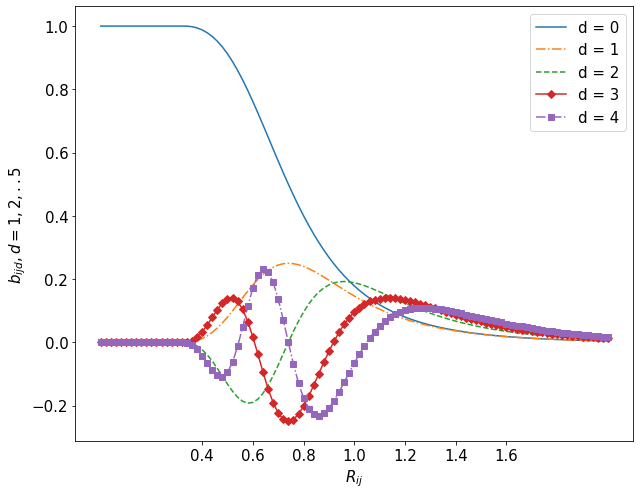

In [36]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})
fig = plt.figure(figsize=(10, 8))
shapes = ["-","-.","--","-D", "-.s"]
legends = []
for d in range(5):
    plt.plot(R, b_ijd_mat[d], shapes[d])
    legends.append("d = "+str(d))
plt.xticks(np.linspace(0.4, 1.6, 7))
plt.legend(legends)
plt.xlabel('$R_{ij}$')
plt.ylabel('$b_{ijd}, d=1,2,..5$')

#### Bonding features of section 8.6, pg. 68

In [37]:
b_ijd_mat_list = []
R = [np.linspace(0, 25, 1001), np.linspace(0, 17.5, 1001)]
e = [2.5, 3]; R_m = [1.9, 2.1]; R_low = [5e-4, 9.1e-5]; R_up = [27.7, 17.9];
for k in range(len(R)):
    t0 = t_R_fun(R_m[k], R_up[k], R_low[k], e[k]) #scalar
    t = t_R_fun(R[k], R_up[k], R_low[k], e[k]) #vector (len(R))
    s = np.array([s_bond_strength(R[k][i], R_up[k], R_low[k], t[i], t0) for i in range(R[k].shape[0])]) #vec (len(R))
    s_prime = s_prime_fun(s) #vec len(R)
    b_ijd_mat_list.append(np.array([p_tchebyshev_pol(deg, s, s_prime) for deg in range(1, 6)])) #matrix (5 (d) x len(R))

C:\Users\beryl\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


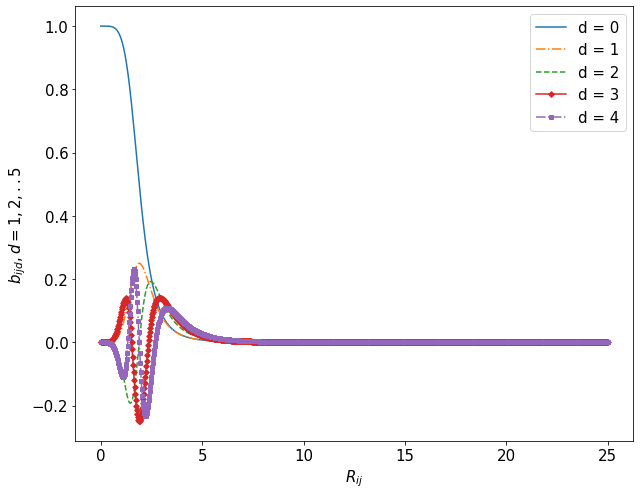

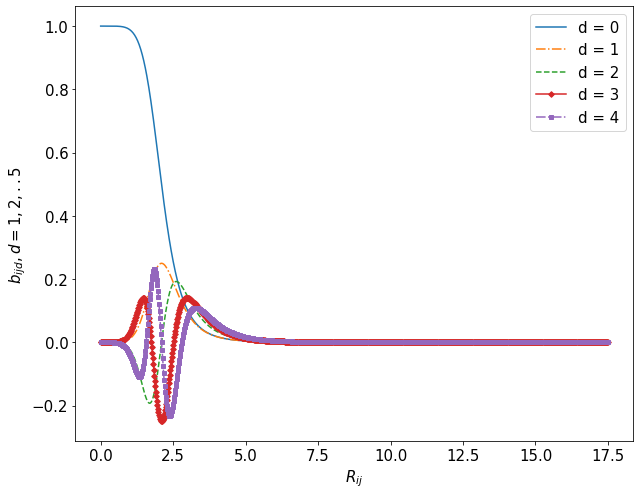

In [38]:
for k in range(len(R)):
    plt.rcParams.update({'font.size': 15})
    fig = plt.figure(figsize=(10, 8))
    for d in range(5):
        plt.plot(R[k], b_ijd_mat_list[k][d], shapes[d], markersize=4)
        dplot = d+1
        legends.append("d = "+str(dplot))
    #plt.xticks(np.linspace(0.4, 1.6, 7))
    plt.legend(legends)
    plt.xlabel('$R_{ij}$')
    plt.ylabel('$b_{ijd}, d=1,2,..5$')

## Tests using files from .py

In [3]:
'''
C = np.array([-6.93189906e+00, -2.52373189e-01,  2.93707834e+00,  2.20223833e+00,
        8.79203285e+00, -7.26578043e+00,  5.80831349e+00,  2.42765209e+00,
        4.96184703e+00,  6.26562614e+00,  5.81888224e+00,  4.03124092e+00,
        9.00502864e+00, -5.25277209e+00,  3.71399035e+00,  2.50168738e+00,
        4.14250973e+00,  3.44427973e+00, -1.38673421e-01,  7.96078787e+00,
        4.97997208e+00, -7.47131293e+00, -7.15781034e+00,  1.73786913e+00,
       -6.13875132e+00, -3.82419945e+00,  5.60083467e+00,  2.55612942e+00,
       -5.92821823e-01, -4.26233593e+00,  6.08461848e+00,  9.80614906e+00,
        7.54644334e+00, -6.68937943e+00,  7.43813315e+00, -3.55419323e+00,
       -3.59828800e+00,  1.98386641e+00, -4.30262221e+00, -3.16894319e+00,
        2.72054758e+00, -6.46987790e+00,  7.96251913e-01, -7.67461242e+00,
       -3.77890242e+00, -8.75390324e+00,  3.43386875e+00, -5.29361073e+00,
        7.83998019e+00,  1.97435469e+00,  8.55990385e+00,  3.57506481e+00,
       -7.39201759e+00, -8.82921771e+00,  7.13659408e+00,  4.88541649e+00,
        8.80453480e+00,  6.74629439e+00, -2.38983796e-01, -8.24477038e+00,
        4.09598301e+00, -2.63345500e+00, -3.73320093e+00, -7.25937164e+00,
       -2.21302732e+00,  4.98929417e-01,  9.41516949e+00,  5.16771465e+00,
       -8.73802948e+00,  2.17325082e-01,  3.74466778e-01,  3.20131471e+00,
        4.03294715e+00,  4.93544616e+00, -3.79629748e+00,  2.01032506e+00,
        1.48500189e+00,  6.69733713e+00,  3.15888169e+00, -7.81157129e+00,
        7.17462313e+00, -3.63105759e+00,  5.56786122e+00, -3.83522791e+00,
       -5.65040718e+00, -6.41935295e+00,  1.11838724e+00, -5.61166632e+00,
       -7.27735867e+00,  3.56423614e+00, -2.56120353e+00,  8.98586355e+00,
        6.63127013e+00, -8.51125911e+00,  8.09628592e+00, -5.70504743e+00,
        3.92881871e-01, -2.35533354e+00, -4.38909526e-01, -1.17065208e+00,
       -1.45265882e+00, -7.45000770e+00,  1.54253740e+00,  9.60334569e+00,
       -6.16167878e+00,  7.31475181e-01,  7.53454908e+00,  5.18396321e+00,
       -8.95454990e+00,  3.63985057e+00, -7.95589280e+00,  3.89698243e+00,
        7.18508058e+00, -4.79838755e+00, -9.98468881e+00, -3.57589044e+00,
        1.70735439e+00,  4.88751272e+00, -4.96730391e+00,  6.07624841e-01,
        7.36494499e+00,  6.54175807e+00, -1.48758569e-02,  2.70874319e+00,
       -8.23263953e-01, -3.38815209e+00, -1.74610017e+01, -5.83398127e+00,
       -2.72402247e+00,  5.56078553e+00,  5.25556283e-01, -9.89821675e+00,
       -3.92124403e+00,  6.24663078e+00,  4.82802467e+00, -8.38483903e+00,
       -9.78420217e+00, -8.75600000e+00,  4.84094902e+00, -3.01167989e-01,
        1.23194789e+00, -9.04098038e-01, -2.08584746e+00,  8.66999242e-01,
       -5.47357799e+00,  7.80779530e+00, -9.23168989e-01,  8.65335715e+00,
       -1.75844957e-01,  5.64613471e+00, -5.34615478e-01,  7.11021651e+00,
       -9.61901541e+00,  4.82930762e+00,  7.61268402e+00,  9.08441100e+00,
        7.37566625e+00,  3.66978815e-01,  5.90971237e+00,  5.44932650e+00,
       -4.25139824e+00,  7.96695567e-01, -5.38238461e+00, -9.30427658e+00,
       -9.84446085e+00,  7.50539356e+00, -6.79324264e+00,  9.75484201e+00,
        3.73048990e+00,  9.50258348e+00, -3.87305345e+00,  5.16101518e+00,
       -4.28876995e+00,  4.84103179e+00, -3.20657613e+00,  3.29429437e+00,
        8.07617507e+00,  2.80029659e-01,  1.09146109e+00,  4.83181627e+00,
        1.94191549e+00, -5.14359663e+00, -1.25784390e+00,  2.01380770e+00,
        5.11252190e+00, -6.25702220e-01,  3.07177459e+00,  4.84151355e+00,
       -2.34436121e+00,  4.61600440e-01, -5.21521764e+00, -2.96827613e+00,
        5.73970533e+00, -3.14923150e+00, -9.06854641e+00,  8.02499097e+00,
        1.23936608e+00, -5.96400013e+00,  8.83564301e+00, -7.98779551e+00,
       -2.84290092e+00, -1.16333678e+00,  5.91338277e+00, -1.00221930e+00,
        1.56025629e+00,  7.26990004e-01, -9.67313066e+00, -7.01076458e+00,
       -1.71540634e+00, -8.59774156e+00,  9.28422463e+00, -3.89206338e+00,
        9.72928712e+00, -6.06209437e+00, -4.90435359e+00,  2.86899960e+00,
        9.94147537e+00,  6.14212829e-01,  9.76362800e+00, -1.29061838e+00,
        4.19350716e+00,  1.24463783e+00, -6.62198592e-02, -6.15108296e+00,
       -9.59860421e+00,  5.84756797e-01, -3.11053189e+00,  5.04017747e+00,
        2.08550035e+00, -1.48180018e+00,  9.38384308e+00, -4.28732527e+00,
        3.66440248e+00, -5.02138673e+00, -4.52845828e-02, -3.30920793e+00,
       -1.41953163e+00, -8.36038299e+00,  5.16058030e+00,  8.30774402e+00,
       -8.20859030e+00, -4.90099400e-01,  7.73094003e+00,  6.18766076e+00,
        6.92802689e+00, -8.91921745e+00,  7.17321129e-01, -4.81529484e-01,
        8.07731474e+00,  6.72184360e+00, -6.08631978e+00,  7.36443506e+00,
       -5.86735497e+00,  7.20745999e+00,  8.12450921e+00,  7.66498129e+00,
        4.74487998e+00, -6.21378574e+00, -3.67213617e+00, -3.25422306e+00,
        5.39247064e+00, -9.21161689e+00,  8.95930158e+00,  6.54263214e+00,
       -7.66683920e+00,  7.03571101e+00, -6.09621610e+00, -5.40331995e+00,
        3.97109914e+00, -2.18796968e+00,  2.80055021e+00,  3.98080337e+00,
       -7.38563236e-01, -4.16091273e+00, -7.36270673e+00,  8.22191965e+00,
       -4.04949318e+00,  6.53840016e+00, -1.74511356e+00, -9.96727311e+00,
       -4.24304486e-01,  8.41840132e+00,  6.09287021e+00, -7.82200243e+00,
        2.76955267e+00, -6.30502223e+00, -2.88515661e-01, -5.83038024e+00,
        7.58582484e+00,  1.57457910e+00, -7.38216010e+00, -9.32304230e+00,
       -3.21138283e+00,  8.85462554e+00, -7.88871762e+00,  7.02570672e+00,
       -1.35666176e+00, -8.37829602e-02, -8.00109654e+00, -1.27237637e-01,
        4.48940146e-02,  3.40437716e-01,  3.63523394e+00,  7.02654570e+00,
       -6.38848402e+00,  1.38096409e+00,  7.44680892e+00, -8.83538811e+00,
        1.23407274e+00,  6.47161990e+00,  2.74277348e+00,  3.88268158e+00,
        2.24312800e+00, -9.37770505e-01, -8.10322782e+00, -2.60976371e+00,
       -3.50403346e+00,  1.98210352e+00,  9.61580047e+00, -9.42722343e+00,
       -7.24560067e+00,  1.13124737e+00,  6.07605045e+00,  1.89587003e+00,
        6.77697035e-01, -8.51673145e+00, -2.45425880e+00,  2.85820020e+00,
       -8.37262325e+00,  7.62101687e+00, -3.13547547e+00,  9.35483695e+00,
        6.09727822e+00, -1.89181982e+00, -2.85393894e+00,  7.94821721e+00,
       -8.31704191e+00,  7.78268803e+00, -5.39630435e+00, -5.13382201e+00,
        8.89919621e+00, -7.58344808e+00,  9.02112448e+00, -6.32461496e+00,
       -6.64204640e+00, -9.98076590e+00, -3.00106720e+00, -3.19844479e+00,
       -8.02753112e+00,  5.03741105e+00, -5.34212002e+00, -8.58863714e+00,
       -3.92465324e+00, -5.73830740e+00,  5.54006026e+00, -4.03895673e+00,
        8.80860211e+00,  7.13329836e+00, -5.55596393e+00,  2.36758043e+00,
       -1.96750439e-01]) # from multistart opt eq 68 [-10, 10.]

'''
C = np.array([-13.86379791,  -0.50474983,   5.87415649,   4.40447489,
        17.58406767, -14.53155896,  11.6166246 ,   4.85530217,
        15.42871694,  12.53125185,  17.16102238,   8.06248193,
        18.01005586, -10.50554536,   7.42798084,   5.00337475,
        12.65654225,   6.88855983,  -0.27734734,  15.921575  ,
         9.95994429, -14.94262636, -14.31562113,   3.47573818,
       -12.27750336,  -7.64840004,  11.03694206,   5.11225747,
        -1.18564345,  -8.5246707 ,  12.16923595,  19.61229954,
        15.09288782, -13.37875863,  14.87626599,  -7.10838735,
        -7.19657592,   3.96773291,  -8.60524455,  -6.33788585,
         5.44109536, -12.93975455,   1.59250398, -15.34922485,
        -7.55780387, -17.50780624,   6.86773715, -10.58722138,
        -3.53306922,   5.27998282,  17.11980658,   7.15012973,
       -14.78403652, -17.6584354 ,  14.27318807,   9.77083253,
        17.60907027,  13.49258892,  -0.47796792, -16.48953982,
         8.19196553,  -5.26691042,  -7.46640156, -14.51874266,
        -4.42605385,   0.99785848,  18.83033963,  13.45071839,
       -17.47605943,   6.27151804,   0.74893394,   6.40263043,
         8.06589401,   9.87089252,  -7.59259489,   6.1531979 ,
         2.97000406,  13.39467383,   6.31776319, -15.62314241,
        14.34924596,  -7.2621152 ,  11.13572265,  -7.67045578,
       -11.30081447, -11.05999919,   2.23677438, -11.22333263,
       -14.55471732,   7.12847238,  -5.1224072 ,  17.97172704,
        13.26254026, -17.0225182 ,  16.19257201, -11.41009492,
         0.78576375,  -4.71066749,  -0.87781905,  -2.34130417,
        -2.90531764, -14.9000154 ,   3.0850748 ,  19.20669137,
       -12.32335756,   1.46295036,  15.06909816,   8.29727239,
       -17.11494588,   7.27970115, -15.9117856 ,   7.79396486,
        14.37016115,  -9.5967751 , -19.96937763,  -7.15178088,
         3.41470878,   9.77502544,  -9.93460782,   1.21524968,
        14.72988998,  13.08351614,  -0.02975171,   5.41748638,
        -1.64652791,  -6.77630418,  22.46542088, -11.66796254,
         8.63580266,  11.12157106,   1.05111257, -19.79643349,
        -7.84248806,  12.49326157,  13.2569068 , -16.76967806,
       -19.56840433, -17.51200001,   9.68189803,  -0.60233598,
         2.46389577,  -1.80819608,  -4.17169491,   1.73399848,
        -7.6089027 ,  15.61559059,  -1.84633798,  17.3067143 ,
        -0.35168991,  11.29226943,  -1.06923096,  14.22043302,
       -19.23803081,   9.65861523,  15.22536805,  18.168822  ,
        14.75133249,   0.73395763,  11.81942475,  10.898653  ,
        -8.50279648,   1.59339113, -10.76476921, -18.60855316,
       -19.6889217 ,  15.01078713, -19.20662787,  17.2132862 ,
         7.46097979,  19.00516696,  -7.7461069 ,  10.32203037,
        -8.57753991,   9.68206358,  -6.41315226,   6.58858873,
        16.15235014,   0.56005932,   2.18292218,   9.66363254,
         3.88383098, -10.28719326,  -2.5156878 ,   4.02761539,
        10.2250438 ,   4.2616111 ,   6.14354918,  12.97175956,
        -4.68872243,   0.92320088, -10.43043527,  -5.93655227,
        11.47941066,  -8.67804591, -18.13709282,  16.04998194,
         2.47873216, -11.92800026,  17.67128602, -15.97559101,
        -5.68580184,  -2.32667355,  11.82676553, -11.7800853 ,
         3.12051258,   1.45398001, -19.34626133, -14.02152917,
        -3.43081269, -17.19548313,  18.56844926,  -7.78412676,
        19.45857424, -12.12418874,  -9.80870718,   5.73799921,
        19.88295074,   1.22842566,  19.52725601,  -2.58123676,
         8.38701432,   2.48927566,  -0.13243972, -12.30216593,
       -19.19720842,   8.25964359, -11.55849152,  10.08035493,
         4.1710007 ,  -2.96360037,  18.76768615,  -8.57465054,
         7.32880496, -10.04277347,  -0.09056917,  -6.61841586,
        -2.83906326, -16.72076599,  10.3211606 ,  16.61548804,
       -16.41718059,  -0.9801988 ,  15.46188006,  12.37532152,
        14.39047844, -17.8384349 ,  10.20540444,  -0.96305897,
        16.15462949,  13.44368719, -12.17263957,  14.72887011,
       -15.71710781,  14.41491999,  16.24901843,  15.32996257,
         9.48975997, -12.42757149,  -7.34427234,  -6.50844611,
        10.78494128, -18.42323378,  17.61223979,  13.08526428,
       -15.33367839,  14.07142202, -12.1924322 , -10.8066399 ,
         7.94219828,  -4.37593936,   5.60110041,   7.96160675,
        -1.47712647,  -8.32182545, -14.72541346,  16.44383929,
        -8.09898636,  13.07680033,  -3.49022711, -19.93454622,
        -0.84860897,  16.83680264,  12.18574043, -15.64400486,
        10.22721951, -17.27911429,  -0.57703132, -11.66076048,
        15.17164967,   3.14915819, -14.76432021, -18.6460846 ,
        -6.42276567,  17.70925108, -15.77743524,  14.05141344,
        -2.71332352,  -0.16756592, -16.00219308,  -0.25447527,
         0.08978803,   0.68087543,   7.27046789,  -8.44221485,
       -12.77696803,  -5.96708932,  14.89361783, -17.67077622,
         2.46814548,  12.94323981,   5.48554696,   7.60802044,
         4.486256  ,  -1.87554101, -16.20645565,  -5.21952743,
        -7.00806691,   3.96420704,  19.23160094, -18.85444687,
       -14.49120134,  -4.47142852,  12.1521009 ,   3.79174007,
         1.35539407, -17.0334629 ,  -4.9085176 ,   5.7164004 ,
       -16.74524651,  15.24203373,  -6.27095095,  18.70967391,
        12.19455644,  -3.78363964,  -5.70787789,  15.89643442,
       -16.63408382,  15.56537607, -10.7926087 , -10.26764402,
        17.79839241, -15.16689615,  18.04224896, -16.10461533,
       -17.42664158, -19.9615318 ,  -6.00213439,  -6.39688958,
       -16.05506224,  10.0748221 , -10.68424004, -17.17727428,
        -7.84930647, -11.4766148 ,  11.08012052,  -8.07791345,
        17.61720423,  14.26659672, -11.11192786,   4.73516087,
        -0.39350088])
# final rmse 0.06272214468023171:
C = np.array([-1.87640188e+02, -1.82833330e+01, -5.74796144e+00,  4.01088756e+00,
        6.13152547e+01,  5.56328317e+00, -1.49858750e-01, -1.40696242e+01,
       -7.15099142e+00, -9.86755906e+00, -1.15321598e+01, -1.65083928e+01,
       -8.22713033e+00,  1.50409263e+01, -8.76747370e+00, -1.43816193e+01,
       -2.55576225e+00,  1.81063504e+01, -9.47654005e-01,  1.74312915e+01,
        1.39164970e+01,  1.71616289e+01, -3.50254258e+00, -1.65538490e+01,
       -6.97500028e-01,  1.96313406e+01, -1.43515388e+01, -8.62999558e+00,
        1.57499984e+00,  1.13305063e+01, -6.65230181e+00, -1.60241573e+01,
        8.24224652e+00,  1.96146913e+01,  1.69241151e+01, -1.96641495e+01,
       -2.87881013e+00,  1.76542195e+01,  2.86396489e+00, -8.66969414e+00,
       -1.23146880e+01, -1.00362777e+01,  1.22564965e+01,  1.68998721e+01,
        1.09527019e+01,  3.01004059e+00, -3.29663007e+00,  4.38914147e+00,
        1.87996158e+01,  1.59957560e+01,  4.28897623e+00,  1.81317023e-01,
       -1.15171384e+01, -1.76024999e+01, -3.71153015e+00,  3.85283991e+00,
       -1.65767908e+01, -1.40802965e+01, -2.43537488e+00, -1.39627130e+00,
       -1.75753426e+01,  1.55124380e+01,  7.18145121e+00,  4.29950950e+00,
        1.83991926e+01,  9.70217746e+00, -1.17071634e+01, -8.61128996e+00,
       -5.91088475e-01,  1.00067067e+01, -1.80287009e+01,  1.01969601e+01,
       -1.62000538e+01, -1.64457001e+01,  4.82887218e+00, -8.98301789e+00,
       -3.91321154e+00,  4.15090934e+00,  1.52099924e+00, -1.64718292e+01,
        7.98150512e+00, -1.89136897e+01, -6.05597032e+00,  1.88122023e+01,
        3.41030845e+00, -1.83994505e+01,  1.70297327e+01, -2.69559259e+00,
        1.66440260e+01, -1.93500233e+01, -4.60184087e+00, -6.06641668e+00,
        5.67304185e+00, -1.73401197e+01, -1.93627865e+00,  1.91385498e+01,
        1.22762247e+01, -4.51725896e+00, -6.07542486e+00,  7.38024238e+00,
       -2.41752785e+00, -8.65119831e+00, -1.96819705e+01,  6.48940036e+00,
       -4.45135680e+00,  1.56253949e+01,  1.85734128e+01,  1.84324666e+01,
       -1.41459129e+01, -1.99247584e+01,  1.07173546e+01, -5.00359715e+00,
       -1.55899126e+01,  6.80272488e+00, -6.14951535e+00, -5.23542464e+00,
        7.07329884e+00,  2.00441993e+00,  1.24020309e+00, -2.21240974e+00,
        1.80786300e+01, -9.44385695e+00,  1.30636026e+01, -8.53108109e+00,
        1.66920285e+00, -5.89429131e+00, -9.06383253e-01, -6.60995853e+00,
       -9.43063644e+00,  1.50796351e+00,  7.95809475e+00,  1.56276920e+01,
        8.14472398e+00,  3.37022191e+00,  4.19096409e+00,  1.03232909e+01,
        1.13244306e+01, -7.02578763e+00, -6.39564645e+00, -1.08845750e+01,
        1.41229688e+01,  1.35767568e+01,  5.30537700e+00, -1.81609578e+01,
        1.41588282e+01,  1.26152451e+01, -1.66450972e+01,  1.93325200e+01,
       -1.71436154e+01, -1.76332669e+01, -1.55007116e+01,  1.82950189e+01,
       -2.97666322e+00,  1.19775766e+01, -1.77816902e+01, -1.18529829e+01,
       -6.90323631e+00, -1.65786415e+01,  1.36380476e+01, -5.23541105e+00,
        3.41116664e+00, -1.86313174e+01, -1.11128322e+01,  1.01146804e+00,
       -6.92548428e+00,  2.75167734e+00, -7.23508582e+00,  3.43410266e-01,
        1.35372101e+00, -1.51873079e+01, -1.09396460e+01,  3.89151413e-01,
        1.90834378e+01, -1.57946231e+01,  3.25751881e-01,  4.93929031e+00,
       -2.81079405e+00, -4.24149775e+00, -1.87472969e+01, -2.80229095e-02,
       -5.33444969e-01, -1.76886107e+01,  8.08295811e+00, -4.95392661e+00,
        3.59576593e+00,  6.92964577e+00,  4.79079323e+00,  1.89982073e+01,
       -1.98581134e+00,  1.44118044e+01,  9.26617170e+01,  2.79488552e+00,
        4.40699122e+00,  5.30030962e+00, -9.99364948e+00,  1.53002224e+01,
        5.54523345e+00,  9.65851859e+00, -1.72142550e+01, -5.43980579e+00,
        7.16594346e+00, -1.42590540e+01, -1.54919169e+01, -1.98198137e+01,
        1.01295712e+01,  6.24776249e+00,  6.25646813e+00, -1.32908217e+00,
        1.59635903e+01,  1.57649455e+01,  7.62237141e+00, -5.33681047e+00,
       -1.10581949e+01,  1.81330932e+01, -1.64205190e+01,  1.45169118e+01,
       -2.18459751e+00, -1.68382277e+01, -1.44559386e+00, -1.97758864e+01,
        1.97160783e+01, -1.48292284e+00,  1.78086816e+01,  2.77419889e+00,
        8.68327470e+00,  7.40985249e+00, -1.64140627e+01, -1.42047665e+01,
       -2.80302672e+00, -5.62223332e+00, -1.93009832e+01,  8.25054482e+00,
        1.24138405e+01, -8.02913526e+00, -1.11037222e+01,  1.70689970e+01,
       -1.15686619e+01, -9.49257617e+00,  1.39839365e+00, -7.17833934e+00,
       -1.89764152e+01, -6.31378724e+00,  1.70940923e+01, -1.36598326e+01,
       -6.58758970e+00, -1.07096847e+01, -1.79511493e+01,  1.53523599e+01,
        9.16613399e-01,  1.41314957e+01, -1.43742327e+00,  9.95297442e+00,
        1.84684233e+01,  1.80478430e+01, -1.19073370e+01,  1.13036960e+01,
        5.91233214e+00, -1.27394823e+01,  7.61021423e+00, -1.41644978e+01,
        1.89100473e+01,  1.65802233e+00, -1.36929045e+01,  1.24802521e+01,
       -1.62903503e+01,  4.31131811e+00, -2.00072825e+00,  2.71638913e+00,
        2.68024329e+00,  1.25328654e+01, -9.86664519e+00, -1.87313116e+01,
        2.64127009e+00, -1.13593271e+01,  1.02602357e+01,  6.12908775e+00,
        7.39238309e+00, -2.91510544e+00, -1.03298830e+00,  2.72689424e+00,
        3.37264784e+00, -7.83242681e+00, -1.93705481e+01,  4.24443265e+00,
       -8.19173630e-01,  5.70413804e+00, -1.99493994e+01,  6.86549084e+00,
       -1.19037344e+01,  7.27239781e+00,  6.82599519e+00, -7.66870936e+00,
       -1.63569710e+01,  4.09469283e+00, -1.78750474e+01,  1.80137074e+01,
        1.04735463e+01,  1.35946506e+01,  1.15771791e+01, -1.95515138e+01,
        1.92418160e+01,  1.67169333e+01,  1.20078849e+01,  1.70369021e+01,
        4.67732308e+01,  1.40559559e+01, -5.13039936e+00, -7.00342487e+00,
        6.64844508e+00,  1.75063518e+01,  8.48379420e+00, -9.41919707e+00,
        1.35918664e+01, -1.15736006e+01, -1.68335501e+01,  6.85586531e+00,
       -2.12374791e+01,  1.61501302e+01,  4.22356796e+00,  1.49840142e+01,
       -1.66267198e+01, -1.89750106e+01, -5.98065452e+00,  6.45668689e+00,
       -1.38741502e+01, -1.12457927e+01,  1.67392701e+01, -1.40264064e-01,
        1.13131548e+01,  1.61064953e+01,  3.02885740e+00,  5.26798262e+00,
        1.39781018e+01, -9.27379369e+00,  7.44845005e+00, -1.93444224e+01,
       -1.37667293e+01, -1.48339572e+01,  1.76396576e+01, -1.63977909e+01,
        1.05181172e+01,  8.80803116e+00, -1.90987443e+01, -2.23108498e+01,
        9.98548912e+00, -1.23656021e+01, -1.32961880e+01, -1.06624197e+01,
       -4.29310614e+00, -2.76896644e+00,  8.43243992e+00,  6.81930801e+00,
        1.86096873e+01,  5.74188921e+00,  1.69155690e+01, -3.67665688e+00,
        5.42390834e+00, -1.34305583e+01,  6.04332813e+00,  2.29334179e+00,
       -6.88882674e+00])

# final rmse 0.03262760560262734:
C = np.array([-1.87795563e+00, -1.91861340e+00,  1.50156931e+01, -9.33080030e+00,
       -2.04900240e+01,  1.20012329e+01,  9.02753646e+00,  1.47224039e+01,
       -2.44959395e+01, -5.47388854e+00,  1.99270662e+01,  1.39876856e+01,
        9.25059843e+00,  1.59392341e+01,  8.98023009e+00, -4.29519397e+00,
        5.36477394e+00, -9.43393777e+00,  1.46497748e+00, -3.71759986e+00,
       -7.09825144e+00, -2.23397039e+01,  1.88731729e+01, -1.28793044e+01,
       -1.70060841e+01, -2.03741860e+01,  3.79091557e+01, -6.85087084e+00,
       -1.37309319e+01, -2.59421310e+00,  1.04709604e+00, -8.66019746e-01,
       -2.07077960e+01, -1.43831834e+01,  1.49009545e+01, -8.89678201e-01,
        1.01211436e+01,  8.85184531e+00, -6.80960728e-01, -1.06805175e+01,
        7.54177913e+00,  1.06686047e+01, -4.99241855e+00, -1.91332794e+01,
       -1.23723398e+01, -4.53316310e-01,  1.29707557e+01,  1.72211459e+01,
       -1.90128388e+01,  2.55670506e+01, -1.50081081e+01,  1.55366117e+00,
        1.02244326e+01,  9.24407136e+00,  1.00358194e+01, -5.57716694e+00,
       -1.00278529e+01,  2.41168133e-01,  1.47467105e+01, -1.31310288e+01,
       -1.95358025e+01, -8.28085573e+00, -6.66993607e-02, -1.38066260e+01,
       -1.75145037e+01,  7.17385957e+00, -5.21794007e+00,  2.64938482e+01,
       -4.23789406e+00, -1.80654335e+00,  1.71564351e+00,  1.67169933e+01,
        5.77395800e-01, -1.80908059e+01,  4.61493406e-01,  2.02141993e+01,
       -2.01938572e-01, -3.04578104e+00, -1.71694432e+01,  6.05577033e+00,
        7.92563793e+00,  3.85306746e+00, -1.65800804e+01, -1.67975182e+01,
       -1.68389111e+01, -8.55909096e+00, -1.57410272e+01,  1.46781089e+01,
        5.27374107e+00, -1.61325354e+01,  6.98455252e+00, -1.15571184e+01,
       -4.55081698e+00, -1.93011769e+01,  1.48998320e+01, -2.09050038e+01,
       -1.40024012e+00, -1.14013879e+01,  8.25050982e+00,  1.19620261e+00,
       -6.96490088e+00,  1.42121644e+01, -1.30757667e+01,  6.92949918e+00,
        4.48319051e+00,  1.24980937e+01,  3.63610301e+00, -2.10243506e+01,
        2.18018523e+01,  1.04603925e+01,  8.12949055e+00,  1.03374875e+01,
        6.34269350e+00, -1.62088200e+01,  1.62746237e+01,  6.56373155e+00,
       -1.77389635e+01, -8.90394123e-01, -1.97854476e+01, -8.89782883e+00,
       -1.90841778e+01,  1.39628784e+01, -7.37468827e+00, -2.31206556e+00,
        1.32259022e+00, -8.53191547e-02, -4.72621523e+01,  1.21345563e+01,
        1.40353664e+01, -8.85520466e+00,  1.27795419e+00, -1.89400186e+01,
        1.57043482e+01, -4.45984193e+00, -1.66093865e+01,  1.81452239e+01,
        7.92686292e+00, -7.76760585e+00,  8.21007776e+00,  1.24245875e+01,
        1.91192042e+01,  1.93572107e+01, -1.74250937e+01,  8.17285107e+00,
       -9.91122113e-01, -1.59489985e+01,  1.53158192e+01,  1.75109857e+01,
       -8.48108942e-01, -2.39356685e-01, -1.32230945e+01, -1.11003960e+01,
        9.92207087e+00,  8.08006450e+00, -1.14107206e+01, -1.19731756e+01,
        1.88535963e+01, -1.05001496e+00, -1.32994007e+01,  9.81357516e+00,
        1.21602821e+01,  1.98283898e+01,  6.42309865e+00, -2.28974182e+00,
        1.47424684e+01,  3.80365690e+00, -8.74217484e+00,  1.77900136e+01,
        1.32544421e+01,  6.77377184e+00,  6.24457939e+00, -1.58274975e+01,
       -1.40755505e+01,  1.75934279e+01,  1.37011124e+01,  7.46627348e+00,
       -5.62331281e-01,  1.71507985e+01,  1.86390582e+01, -9.98679175e+00,
        1.50365180e+01, -1.35527466e+01,  2.91010895e+00,  5.79765426e+00,
        7.14420836e-01, -1.65938545e+02, -1.12668379e+00, -2.52372177e+01,
        1.75166692e+01,  1.78616586e+01,  8.95404572e+00, -3.33990459e+00,
       -1.81110109e+01,  1.61723904e+01,  1.96480952e+01,  8.88242662e+00,
       -1.30982276e+01, -1.55347443e+01,  7.53421703e+00,  1.14267822e+01,
       -1.72360548e+01, -1.35283041e+01,  5.74531456e+00, -2.27316185e+01,
        1.44220904e+00,  1.27536860e+01,  4.42123298e-01, -6.99439948e+00,
       -3.47642120e+00,  2.01613821e+00, -4.93407247e+00,  5.37928700e+00,
        1.68626856e+01,  1.44729784e+01,  8.74861383e+00,  2.66045043e+00,
        1.98582881e+01,  1.65623665e+01, -1.06086782e+01,  1.03117876e+01,
       -9.29149493e+00,  1.07240128e+00, -9.09863617e+00,  1.57194919e+01,
       -2.82368957e+00, -3.59079451e+00,  9.03758942e+01,  5.73588178e-01,
        1.26295959e+00, -3.11185369e+00,  2.66233623e+00,  3.97556215e+00,
       -1.03489940e+00,  1.38372227e+01, -3.57948580e+00,  1.42635524e+01,
        1.10750286e+01,  1.08769904e+01, -6.66501035e+00, -2.37321817e+00,
        2.46232915e+00, -2.96585231e+00,  1.02084052e+01,  1.73233878e+01,
       -2.53229537e+01, -1.31573857e+01,  8.14782362e-01, -8.67708482e+00,
        3.67992641e+00,  5.16697348e-01, -1.56519362e+01, -1.75417886e+01,
       -2.50985494e+01, -2.60000987e+00,  7.82624979e-02, -1.26720891e+01,
        1.97426028e+01,  6.89177188e+00,  1.99337417e+00,  2.83059072e+00,
       -6.44218189e+00,  1.69281891e+01, -1.78042349e+01,  1.82418430e+01,
       -1.47772763e+01, -7.31105266e+00, -7.62055237e+00,  1.91780103e+01,
        9.54083786e+00,  2.66753091e+00,  9.27652667e+00, -1.01888600e+01,
       -1.40856159e+01, -1.66124416e+01, -8.08942285e+00, -5.89586257e+00,
       -9.71251639e-01,  3.46197139e+00,  3.37329644e+00,  1.58626185e+01,
        7.55741389e+00, -1.41418257e+01, -1.97771409e+01,  3.76124525e+00,
        3.40382944e+01, -1.46312443e+01, -8.26155049e-01, -1.56720686e+01,
       -1.29051451e+01, -7.70439847e+00,  2.48764867e+00, -1.80561262e+01,
        5.77082516e+00,  5.77410839e+00, -1.80945795e+01, -1.43957742e+00,
       -6.11111420e+00,  8.14986545e+00,  3.40722808e+00, -1.22806837e+00,
       -1.78880710e+00, -1.67855710e+01,  5.73672178e+00,  2.58894867e+01,
        1.71337745e+00, -1.35041336e+01, -3.95850984e+00, -1.82506356e+01,
        6.57173159e+00, -1.80702819e+01,  1.14618731e+01,  1.14000203e+01,
        1.90188717e+01, -1.26986984e+01,  4.08345173e+00, -4.97197941e+00,
       -1.97221890e+01, -2.82206596e+00, -1.14848712e+01, -6.64236877e-01,
       -1.00776537e+01,  1.54528890e+01,  7.51645670e+00, -6.83072425e+00,
        4.26779057e+00,  1.66019060e+01,  1.51551296e+01, -1.00310342e+01,
       -5.13341588e+00,  5.12922612e+00,  3.53684622e+00,  1.97886767e+01,
        1.59908740e+00, -2.48171972e+00,  1.32067601e+01, -5.19727058e+00,
        7.37826303e+00, -1.54304385e+00,  1.56123389e+01,  1.90782786e+01,
       -3.45283973e+00, -1.78430638e+01,  9.61373907e+00,  2.54995316e+01,
        3.83307959e+01,  3.53638311e+00,  1.33698746e+01,  1.59677574e+01,
       -4.79445332e+00,  3.97685856e+00,  1.51473870e+01,  1.67611921e+01,
       -1.37376396e+01,  1.37256649e-01,  5.83817066e+00, -1.87192836e+01,
        3.72299545e+00,  1.20909730e+00,  5.69318630e+00, -1.06629713e+01,
        1.74257100e+01])

In [4]:
# load data and coordinates:
H3_data = np.load("data/h3/h3_data.npy")
R = H3_data[:, 0:3]; V = H3_data[:, 3]
X = np.load("data/h3/h3_coord.npy")
# get subset:
sub_V = V[:100]
sub_R = R[:100]
sub_X = X[:100]

# fixed parameters:
num_basis = 59; max_deg = 5; num_atom = 3; e = 3; g = 6;
indexer = bond_pmodel.atom_indexer(num_atom)

In [5]:
# rmse:
V_pred = bond_pmodel.f_pot_bond_wrapper_trpp(C, num_basis, sub_R, sub_X, indexer, num_atom, max_deg, e, g)
rmse = pmodel.RMSE(V_pred, sub_V)
print("R_h, R_low, R_0, R_m, R_up, R_C", C[1:7])
print("pred, actual")
for i in range(V_pred.shape[0]):
    print(V_pred[i], sub_V[i])
print("RMSE",rmse)

U
[[2.53919884e-83 2.39317966e-83 2.48675897e-83 2.48675897e-83
  2.30273274e-83 2.30273274e-83 2.15671355e-83 2.03891273e-83
  2.11870650e-83 2.11870650e-83 2.11870650e-83 1.97268732e-83
  1.97268732e-83 1.85488650e-83 1.75847516e-83 1.82666814e-83
  1.82666814e-83 1.82666814e-83 1.70886732e-83 1.70886732e-83
  1.61245598e-83 1.53255262e-83 1.59106650e-83 1.59106650e-83
  1.59106650e-83 1.49465516e-83 1.49465516e-83 1.41475180e-83
  1.41475180e-83 1.34779200e-83 1.29112393e-83 1.39824381e-83
  1.39824381e-83 1.39824381e-83 1.31834045e-83 1.31834045e-83
  1.25138066e-83 1.25138066e-83 1.19471259e-83 1.14633031e-83
  1.23843709e-83 1.23843709e-83 1.23843709e-83 1.17147730e-83
  1.17147730e-83 1.11480923e-83 1.11480923e-83 1.06642695e-83
  1.10451751e-83 1.10451751e-83 1.10451751e-83 1.04784944e-83
  1.04784944e-83 9.99467162e-84 9.99467162e-84 9.21741787e-84
  9.91181370e-84 9.91181370e-84 9.91181370e-84 9.42799092e-84
  9.42799092e-84 8.65073718e-84 8.05957199e-84 8.94416815e-84
  8.94

In [34]:
# test random:
print("min R, max R",np.min(sub_R), np.max(sub_R))
C[[1,2,5,6]] = [1e-3,1e-4,4.1,7.] # (1,2,5,6) = (R_h, R_low, R_up, R_C)
C[0] = 1e-5
print(sub_R[:4])
V_pred = bond_pmodel.f_pot_bond_wrapper_trpp(C, num_basis, sub_R[:4], sub_X[:4], indexer, num_atom, max_deg, e, g)
for i in range(V_pred.shape[0]):
    print(V_pred[i], sub_V[i])


min R, max R 1.1 3.786374
[[1.1      1.3      1.335106]
 [1.1      1.4      1.402337]
 [1.2      1.2      1.271806]
 [1.2      1.2      1.324649]]
C, R_h, R_C, R_0 1.0002000200013335 1.0202013400267558 394.4088348897797 19.399399066640516
U
[[3.96002367e+34 3.71937120e+34 2.66185956e+34 2.66185956e+34]
 [3.85783935e+34 3.71527775e+34 2.25178347e+34 2.07452434e+34]
 [1.53349721e+34 1.15028314e+34 2.25178347e+34 2.07452434e+34]]
b
[[[ 1.  1.  1.]
  [ 1.  1.  1.]
  [ 1.  1.  1.]
  [ 1.  1.  1.]]

 [[ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]]

 [[-0. -0. -0.]
  [-0. -0. -0.]
  [-0. -0. -0.]
  [-0. -0. -0.]]

 [[ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]]

 [[ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]]]
phi
[[[3.96002367e+34 3.71937120e+34 2.66185956e+34 2.66185956e+34]
  [2.00000000e+00 2.00000000e+00 2.00000000e+00 2.00000000e+00]
  [7.92004735e+34 7.43874239e+34 5.32371911e+34 5.32371911e+34]
  [4.00000000e+00 4.00000000e+00 4.000000

### Check RMSE of C from files

In [245]:
# load data and coordinates:
H3_data = np.load("data/h3/h3_data.npy")
R = H3_data[:, 0:3]; V = H3_data[:, 3]
X = np.load("data/h3/h3_coord.npy")
# get subset:
sub_V = V[:100]
sub_R = R[:100]
sub_X = X[:100]

# fixed parameters:
num_basis = 59; max_deg = 5; num_atom = 3; e = 3; g = 6;
indexer = bond_pmodel.atom_indexer(num_atom)

In [246]:
C = np.loadtxt("c_params.out") # file containing C
V_pred = bond_pmodel.f_pot_bond_wrapper_trpp(C, num_basis, sub_R, sub_X, indexer, num_atom, max_deg, e, g)
rmse = pmodel.RMSE(V_pred, sub_V)
print("R_h, R_low, R_0, R_m, R_up, R_C", C[1:7])
print("pred, actual")
for i in range(V_pred.shape[0]):
    print(V_pred[i], sub_V[i])
print("RMSE",rmse)

R_h, R_low, R_0, R_m, R_up, R_C [-15.89242005  -9.92235219 -12.42922767 -13.90806572  11.50456489
  16.81900421]
pred, actual
-1.0683808129257915e-07 0.20189132
-1.068380812925923e-07 0.178711569
-1.0683808129257465e-07 0.212669847
-1.0683808129257883e-07 0.202513057
-1.0683808129258723e-07 0.187458064
-1.0683808129259154e-07 0.178838429
-1.068380812926043e-07 0.157832837
-1.0683808129261727e-07 0.139622114
-1.0683808129259477e-07 0.180014547
-1.0683808129259935e-07 0.16961101
-1.0683808129260382e-07 0.160482058
-1.0683808129261159e-07 0.150945397
-1.0683808129261621e-07 0.143217169
-1.0683808129262884e-07 0.127016135
-1.0683808129264186e-07 0.112480998
-1.0683808129261854e-07 0.14893591
-1.0683808129262341e-07 0.139457551
-1.0683808129262824e-07 0.131035979
-1.0683808129263559e-07 0.125555429
-1.0683808129264059e-07 0.118449818
-1.0683808129265332e-07 0.105824502
-1.068380812926665e-07 0.094082333
-1.0683808129264212e-07 0.127488391
-1.0683808129264739e-07 0.118668371
-1.0683808129265

### Basis functions (U,Y,G) and phi matrix check:

In [58]:
# U check:
bond_pmodel.V_ref_pairpot(2, 1, np.sqrt(2), 3, np.sqrt(2), 2) # output is correct

-25.0

In [81]:
# Y ceck:
# dummy b:
b = np.zeros((2, 4, 3)) # d = 2, data = 4, numatom = dof = 3 (special case)
b[0] = 1
b[1] = -5
for i in range(b.shape[1]):
    b[:, i] += i
for i in range(b.shape[1]):
    if i % 2 == 0:
        b[:,:,i] *= -1
print("b")
print(b)
indexer = bond_pmodel.atom_indexer(num_atom)
Y = bond_pmodel.Y_coord_mat(b, indexer)
print("Y")
print(Y)
# test i=2, d=1 -> i=1, d=0 (py index) :
print(b[0,:,0] + b[0,:,2])
print(Y[1,0]) # result is correct

b
[[[-1.  1. -1.]
  [-2.  2. -2.]
  [-3.  3. -3.]
  [-4.  4. -4.]]

 [[ 5. -5.  5.]
  [ 4. -4.  4.]
  [ 3. -3.  3.]
  [ 2. -2.  2.]]]
Y
[[[ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]]

 [[-2. -4. -6. -8.]
  [10.  8.  6.  4.]]

 [[ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]]]
[-2. -4. -6. -8.]
[-2. -4. -6. -8.]


In [ ]:
# G check:
# check r first:
delta = np.zeros((3,3))

In [14]:
x = y = z = np.arange(0.0,5.0,1.0)
np.savetxt('test.out', x, delimiter=',')   # X is an array
#np.savetxt('test.out', (x,y,z))   # x,y,z equal sized 1D arrays
#np.savetxt('test.out', x, fmt='%1.4e')   # use exponential notation

In [17]:
np.loadtxt("test.out")

array([0., 1., 2., 3., 4.])

#### Array manipulation experiments

In [31]:
# array manipulation experiments
A = np.arange(48).reshape((2, 4, 6))
A[1] += 1
B = np.arange(72).reshape((4, 6, 3))
print(A)
print(B)
Z = np.zeros((2,4,6,3))
# naive way:
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        for k in range(A.shape[2]):
            Z[i][j][k] = A[i][j][k] * B[j][k]
np.set_printoptions(suppress=True)
print(Z)

[[[ 0  1  2  3  4  5]
  [ 6  7  8  9 10 11]
  [12 13 14 15 16 17]
  [18 19 20 21 22 23]]

 [[25 26 27 28 29 30]
  [31 32 33 34 35 36]
  [37 38 39 40 41 42]
  [43 44 45 46 47 48]]]
[[[ 0  1  2]
  [ 3  4  5]
  [ 6  7  8]
  [ 9 10 11]
  [12 13 14]
  [15 16 17]]

 [[18 19 20]
  [21 22 23]
  [24 25 26]
  [27 28 29]
  [30 31 32]
  [33 34 35]]

 [[36 37 38]
  [39 40 41]
  [42 43 44]
  [45 46 47]
  [48 49 50]
  [51 52 53]]

 [[54 55 56]
  [57 58 59]
  [60 61 62]
  [63 64 65]
  [66 67 68]
  [69 70 71]]]
[[[[   0.    0.    0.]
   [   3.    4.    5.]
   [  12.   14.   16.]
   [  27.   30.   33.]
   [  48.   52.   56.]
   [  75.   80.   85.]]

  [[ 108.  114.  120.]
   [ 147.  154.  161.]
   [ 192.  200.  208.]
   [ 243.  252.  261.]
   [ 300.  310.  320.]
   [ 363.  374.  385.]]

  [[ 432.  444.  456.]
   [ 507.  520.  533.]
   [ 588.  602.  616.]
   [ 675.  690.  705.]
   [ 768.  784.  800.]
   [ 867.  884.  901.]]

  [[ 972.  990. 1008.]
   [1083. 1102. 1121.]
   [1200. 1220. 1240.]
   [1323. 1

In [29]:
B = np.transpose(B, (2, 0, 1))
B

array([[[ 0,  3,  6,  9, 12, 15],
        [18, 21, 24, 27, 30, 33],
        [36, 39, 42, 45, 48, 51],
        [54, 57, 60, 63, 66, 69]],

       [[ 1,  4,  7, 10, 13, 16],
        [19, 22, 25, 28, 31, 34],
        [37, 40, 43, 46, 49, 52],
        [55, 58, 61, 64, 67, 70]],

       [[ 2,  5,  8, 11, 14, 17],
        [20, 23, 26, 29, 32, 35],
        [38, 41, 44, 47, 50, 53],
        [56, 59, 62, 65, 68, 71]]])

In [30]:
Y = np.zeros((2, 3, 4, 6))
iter0 = range(Y.shape[0])
for i in iter0:
    Y[i] = A[i]*B
print(Y)
Y = np.transpose(Y, (0,2,3,1))
Y

[[[[   0.    3.   12.   27.   48.   75.]
   [ 108.  147.  192.  243.  300.  363.]
   [ 432.  507.  588.  675.  768.  867.]
   [ 972. 1083. 1200. 1323. 1452. 1587.]]

  [[   0.    4.   14.   30.   52.   80.]
   [ 114.  154.  200.  252.  310.  374.]
   [ 444.  520.  602.  690.  784.  884.]
   [ 990. 1102. 1220. 1344. 1474. 1610.]]

  [[   0.    5.   16.   33.   56.   85.]
   [ 120.  161.  208.  261.  320.  385.]
   [ 456.  533.  616.  705.  800.  901.]
   [1008. 1121. 1240. 1365. 1496. 1633.]]]


 [[[   0.   78.  162.  252.  348.  450.]
   [ 558.  672.  792.  918. 1050. 1188.]
   [1332. 1482. 1638. 1800. 1968. 2142.]
   [2322. 2508. 2700. 2898. 3102. 3312.]]

  [[  25.  104.  189.  280.  377.  480.]
   [ 589.  704.  825.  952. 1085. 1224.]
   [1369. 1520. 1677. 1840. 2009. 2184.]
   [2365. 2552. 2745. 2944. 3149. 3360.]]

  [[  50.  130.  216.  308.  406.  510.]
   [ 620.  736.  858.  986. 1120. 1260.]
   [1406. 1558. 1716. 1880. 2050. 2226.]
   [2408. 2596. 2790. 2990. 3196. 3408.]]]]


array([[[[   0.,    0.,    0.],
         [   3.,    4.,    5.],
         [  12.,   14.,   16.],
         [  27.,   30.,   33.],
         [  48.,   52.,   56.],
         [  75.,   80.,   85.]],

        [[ 108.,  114.,  120.],
         [ 147.,  154.,  161.],
         [ 192.,  200.,  208.],
         [ 243.,  252.,  261.],
         [ 300.,  310.,  320.],
         [ 363.,  374.,  385.]],

        [[ 432.,  444.,  456.],
         [ 507.,  520.,  533.],
         [ 588.,  602.,  616.],
         [ 675.,  690.,  705.],
         [ 768.,  784.,  800.],
         [ 867.,  884.,  901.]],

        [[ 972.,  990., 1008.],
         [1083., 1102., 1121.],
         [1200., 1220., 1240.],
         [1323., 1344., 1365.],
         [1452., 1474., 1496.],
         [1587., 1610., 1633.]]],


       [[[   0.,   25.,   50.],
         [  78.,  104.,  130.],
         [ 162.,  189.,  216.],
         [ 252.,  280.,  308.],
         [ 348.,  377.,  406.],
         [ 450.,  480.,  510.]],

        [[ 558.,  589.,  620

In [43]:
# for delta matrix computation
A = np.arange(72).reshape((6,4,3))
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        if j%2 != 0:
            A[i][j] *= -1
A

array([[[  0,   1,   2],
        [ -3,  -4,  -5],
        [  6,   7,   8],
        [ -9, -10, -11]],

       [[ 12,  13,  14],
        [-15, -16, -17],
        [ 18,  19,  20],
        [-21, -22, -23]],

       [[ 24,  25,  26],
        [-27, -28, -29],
        [ 30,  31,  32],
        [-33, -34, -35]],

       [[ 36,  37,  38],
        [-39, -40, -41],
        [ 42,  43,  44],
        [-45, -46, -47]],

       [[ 48,  49,  50],
        [-51, -52, -53],
        [ 54,  55,  56],
        [-57, -58, -59]],

       [[ 60,  61,  62],
        [-63, -64, -65],
        [ 66,  67,  68],
        [-69, -70, -71]]])

In [85]:
#naive way:
n = 4
dof = int(n*(n-1)/2) # degree of freedom
Z = np.zeros((6, dof, 3))
iter_atom = range(n)
for d in range(6):
    # for each data, loop the atoms:
    dof_counter = 0
    for i in iter_atom:
        for j in iter_atom:
            if i < j:
                Z[d][dof_counter] = A[d][j] - A[d][i]
                dof_counter += 1
print(Z)

[[[  -3.   -5.   -7.]
  [   6.    6.    6.]
  [  -9.  -11.  -13.]
  [   9.   11.   13.]
  [  -6.   -6.   -6.]
  [ -15.  -17.  -19.]]

 [[ -27.  -29.  -31.]
  [   6.    6.    6.]
  [ -33.  -35.  -37.]
  [  33.   35.   37.]
  [  -6.   -6.   -6.]
  [ -39.  -41.  -43.]]

 [[ -51.  -53.  -55.]
  [   6.    6.    6.]
  [ -57.  -59.  -61.]
  [  57.   59.   61.]
  [  -6.   -6.   -6.]
  [ -63.  -65.  -67.]]

 [[ -75.  -77.  -79.]
  [   6.    6.    6.]
  [ -81.  -83.  -85.]
  [  81.   83.   85.]
  [  -6.   -6.   -6.]
  [ -87.  -89.  -91.]]

 [[ -99. -101. -103.]
  [   6.    6.    6.]
  [-105. -107. -109.]
  [ 105.  107.  109.]
  [  -6.   -6.   -6.]
  [-111. -113. -115.]]

 [[-123. -125. -127.]
  [   6.    6.    6.]
  [-129. -131. -133.]
  [ 129.  131.  133.]
  [  -6.   -6.   -6.]
  [-135. -137. -139.]]]


In [86]:
#print(A[:, [0,1]])
print(np.diff(A[:, [0,1]], axis=1).shape)
Z = Z.reshape((6, dof, 1, 3)) # add 1 due to the artefact of numpy differences (reduces shape to shape-1)
dof_counter = 0
for i in iter_atom:
    for j in iter_atom:
        if i < j:
            Z[:, dof_counter] = np.diff(A[:, [i,j]], axis=1)
            dof_counter += 1
Z = Z.reshape((6, dof, 3))
print(Z)

(6, 1, 3)
[[[  -3.   -5.   -7.]
  [   6.    6.    6.]
  [  -9.  -11.  -13.]
  [   9.   11.   13.]
  [  -6.   -6.   -6.]
  [ -15.  -17.  -19.]]

 [[ -27.  -29.  -31.]
  [   6.    6.    6.]
  [ -33.  -35.  -37.]
  [  33.   35.   37.]
  [  -6.   -6.   -6.]
  [ -39.  -41.  -43.]]

 [[ -51.  -53.  -55.]
  [   6.    6.    6.]
  [ -57.  -59.  -61.]
  [  57.   59.   61.]
  [  -6.   -6.   -6.]
  [ -63.  -65.  -67.]]

 [[ -75.  -77.  -79.]
  [   6.    6.    6.]
  [ -81.  -83.  -85.]
  [  81.   83.   85.]
  [  -6.   -6.   -6.]
  [ -87.  -89.  -91.]]

 [[ -99. -101. -103.]
  [   6.    6.    6.]
  [-105. -107. -109.]
  [ 105.  107.  109.]
  [  -6.   -6.   -6.]
  [-111. -113. -115.]]

 [[-123. -125. -127.]
  [   6.    6.    6.]
  [-129. -131. -133.]
  [ 129.  131.  133.]
  [  -6.   -6.   -6.]
  [-135. -137. -139.]]]


In [70]:
X = np.array([[0,2,0],[-1,1,1], [2,1,2]])
np.diff(X[1:3], axis=0)

array([[3, 0, 1]])

In [4]:
'''
computes the reference energy matrix, U[i] = \sum V_ij, shape = (num_atom, num_data)
parameters:
    - R_mat = distance matrix, shape = (num_data, dof)
    - C, R_h, R_C, R_0, g = scalar constants
    - indexer = indexer matrix, shape = (num_atom, num_atom-1)
'''
num_data = 5; dof = 6; num_atom = 4; g=2
R_h = 7; R_C = 22
R = np.arange(30).reshape((num_data, dof)).astype("float64")
print(R)
Vref = np.zeros((num_data, dof))
# transposed order:
for i in range(num_data):
    for j in range(dof):
        if R[i][j] <= R_h:
            Vref[i][j] = np.inf
        elif R_h < R[i][j] <= R_C:
            R2 = R[i][j]**2
            
            Vref[i][j] = R2 + 1
        else:
            Vref[i][j] = 0
Vref



[[ 0.  1.  2.  3.  4.  5.]
 [ 6.  7.  8.  9. 10. 11.]
 [12. 13. 14. 15. 16. 17.]
 [18. 19. 20. 21. 22. 23.]
 [24. 25. 26. 27. 28. 29.]]


array([[ inf,  inf,  inf,  inf,  inf,  inf],
       [ inf,  inf,  65.,  82., 101., 122.],
       [145., 170., 197., 226., 257., 290.],
       [325., 362., 401., 442., 485.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.]])

In [68]:
T=R+2
low_idx = np.where(R <= R_h)
mid_idx = np.where((R_h < R) & (R <= R_C))
up_idx = np.where(R > R_C)
R[low_idx] = np.inf
R[up_idx] = 0
T_mid = T[mid_idx]
R[mid_idx] = T_mid + 1
R

array([[inf, inf, inf, inf, inf, inf],
       [inf, inf, 11., 12., 13., 14.],
       [15., 16., 17., 18., 19., 20.],
       [21., 22., 23., 24., 25.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.]])

In [10]:
L = (R <= R_h)
M = (R <= R_C) & ~L
R[L] = np.inf
R[M] = T
R

NameError: name 'T' is not defined

In [113]:
num_atom, max_d, num_data, num_elem = 4, 2, 5, 3
tot = num_atom*max_d*num_data*num_elem
print(tot)

r = np.arange(tot).reshape(num_atom, max_d, num_data, num_elem)
print(r)
G = np.zeros((num_atom, max_d, max_d, num_data))

120
[[[[  0   1   2]
   [  3   4   5]
   [  6   7   8]
   [  9  10  11]
   [ 12  13  14]]

  [[ 15  16  17]
   [ 18  19  20]
   [ 21  22  23]
   [ 24  25  26]
   [ 27  28  29]]]


 [[[ 30  31  32]
   [ 33  34  35]
   [ 36  37  38]
   [ 39  40  41]
   [ 42  43  44]]

  [[ 45  46  47]
   [ 48  49  50]
   [ 51  52  53]
   [ 54  55  56]
   [ 57  58  59]]]


 [[[ 60  61  62]
   [ 63  64  65]
   [ 66  67  68]
   [ 69  70  71]
   [ 72  73  74]]

  [[ 75  76  77]
   [ 78  79  80]
   [ 81  82  83]
   [ 84  85  86]
   [ 87  88  89]]]


 [[[ 90  91  92]
   [ 93  94  95]
   [ 96  97  98]
   [ 99 100 101]
   [102 103 104]]

  [[105 106 107]
   [108 109 110]
   [111 112 113]
   [114 115 116]
   [117 118 119]]]]


In [94]:
for i in range(num_atom): # each atom:
    for d1 in range(max_d): # each dim1:
        for d2 in range(max_d): # each dim2:
            G[i][d1][d2] = np.sum(r[i][d1]*r[i][d2], axis=-1)
            print(i, d1, d2)
            print(r[i][d1]*r[i][d2])
            print(np.sum(r[i][d1]*r[i][d2], axis=-1))
print("G")
print(G)
print(G.shape)

0 0 0
[[  0   1   4]
 [  9  16  25]
 [ 36  49  64]
 [ 81 100 121]
 [144 169 196]]
[  5  50 149 302 509]
0 0 1
[[  0  16  34]
 [ 54  76 100]
 [126 154 184]
 [216 250 286]
 [324 364 406]]
[  50  230  464  752 1094]
0 1 0
[[  0  16  34]
 [ 54  76 100]
 [126 154 184]
 [216 250 286]
 [324 364 406]]
[  50  230  464  752 1094]
0 1 1
[[225 256 289]
 [324 361 400]
 [441 484 529]
 [576 625 676]
 [729 784 841]]
[ 770 1085 1454 1877 2354]
1 0 0
[[ 900  961 1024]
 [1089 1156 1225]
 [1296 1369 1444]
 [1521 1600 1681]
 [1764 1849 1936]]
[2885 3470 4109 4802 5549]
1 0 1
[[1350 1426 1504]
 [1584 1666 1750]
 [1836 1924 2014]
 [2106 2200 2296]
 [2394 2494 2596]]
[4280 5000 5774 6602 7484]
1 1 0
[[1350 1426 1504]
 [1584 1666 1750]
 [1836 1924 2014]
 [2106 2200 2296]
 [2394 2494 2596]]
[4280 5000 5774 6602 7484]
1 1 1
[[2025 2116 2209]
 [2304 2401 2500]
 [2601 2704 2809]
 [2916 3025 3136]
 [3249 3364 3481]]
[ 6350  7205  8114  9077 10094]
2 0 0
[[3600 3721 3844]
 [3969 4096 4225]
 [4356 4489 4624]
 [4761 4

In [114]:
for i in range(num_atom): # each atom:
    for d1 in range(max_d): # each dim1:
        for d2 in range(max_d): # each dim2:
            if d1 <= d2:
                G[i][d1][d2] = np.sum(r[i][d1]*r[i][d2], axis=-1)
            else: 
                G[i][d1][d2] = G[i][d2][d1]
print("G")
print(G)

G
[[[[5.0000e+00 5.0000e+01 1.4900e+02 3.0200e+02 5.0900e+02]
   [5.0000e+01 2.3000e+02 4.6400e+02 7.5200e+02 1.0940e+03]]

  [[5.0000e+01 2.3000e+02 4.6400e+02 7.5200e+02 1.0940e+03]
   [7.7000e+02 1.0850e+03 1.4540e+03 1.8770e+03 2.3540e+03]]]


 [[[2.8850e+03 3.4700e+03 4.1090e+03 4.8020e+03 5.5490e+03]
   [4.2800e+03 5.0000e+03 5.7740e+03 6.6020e+03 7.4840e+03]]

  [[4.2800e+03 5.0000e+03 5.7740e+03 6.6020e+03 7.4840e+03]
   [6.3500e+03 7.2050e+03 8.1140e+03 9.0770e+03 1.0094e+04]]]


 [[[1.1165e+04 1.2290e+04 1.3469e+04 1.4702e+04 1.5989e+04]
   [1.3910e+04 1.5170e+04 1.6484e+04 1.7852e+04 1.9274e+04]]

  [[1.3910e+04 1.5170e+04 1.6484e+04 1.7852e+04 1.9274e+04]
   [1.7330e+04 1.8725e+04 2.0174e+04 2.1677e+04 2.3234e+04]]]


 [[[2.4845e+04 2.6510e+04 2.8229e+04 3.0002e+04 3.1829e+04]
   [2.8940e+04 3.0740e+04 3.2594e+04 3.4502e+04 3.6464e+04]]

  [[2.8940e+04 3.0740e+04 3.2594e+04 3.4502e+04 3.6464e+04]
   [3.3710e+04 3.5645e+04 3.7634e+04 3.9677e+04 4.1774e+04]]]]


In [58]:
num_atom, num_basis, num_data = 4, 3, 2
size = num_atom*num_basis*num_data
print(size)
phi = np.arange(size).reshape((num_atom, num_basis, num_data))
print(phi)
T = np.arange(2*num_basis).reshape((2, num_basis))
print(T)
Z = np.zeros((num_atom, num_data))
for i in range(num_atom):
    numer = 0; denom = 0
    for k in range(num_basis):
        numer += T[0][k]*phi[i,k] #scalar*vector
        denom += T[1][k]*phi[i,k] #scalar*vector
        print(i, k, T[0][k]*phi[i,k], T[1][k]*phi[i,k])
    numer = numer**2
    denom = denom**2 + 1
    Z[i] = numer / denom
print(np.sum(Z, axis=0))

24
[[[ 0  1]
  [ 2  3]
  [ 4  5]]

 [[ 6  7]
  [ 8  9]
  [10 11]]

 [[12 13]
  [14 15]
  [16 17]]

 [[18 19]
  [20 21]
  [22 23]]]
[[0 1 2]
 [3 4 5]]
0 0 [0 0] [0 3]
0 1 [2 3] [ 8 12]
0 2 [ 8 10] [20 25]
1 0 [0 0] [18 21]
1 1 [8 9] [32 36]
1 2 [20 22] [50 55]
2 0 [0 0] [36 39]
2 1 [14 15] [56 60]
2 2 [32 34] [80 85]
3 0 [0 0] [54 57]
3 1 [20 21] [80 84]
3 2 [44 46] [110 115]
[[0.12738854 0.10555903]
 [0.07839216 0.07660422]
 [0.07152273 0.07091591]
 [0.06879755 0.06849566]]


In [69]:
Z = np.sum(np.matmul(T, phi), axis=1)
print(Z, Z.shape)
Z = np.matmul(T, phi)
print(Z, Z.shape)
ZT = Z.transpose(1,0,2)
print(ZT)
ZT = ZT[0]**2/(ZT[1]**2 + 1)
print(ZT, ZT.shape)


[[ 38  53]
 [128 143]
 [218 233]
 [308 323]] (4, 2)
[[[ 10  13]
  [ 28  40]]

 [[ 28  31]
  [100 112]]

 [[ 46  49]
  [172 184]]

 [[ 64  67]
  [244 256]]] (4, 2, 2)
[[[ 10  13]
  [ 28  31]
  [ 46  49]
  [ 64  67]]

 [[ 28  40]
  [100 112]
  [172 184]
  [244 256]]]
[[0.12738854 0.10555903]
 [0.07839216 0.07660422]
 [0.07152273 0.07091591]
 [0.06879755 0.06849566]] (4, 2)


In [68]:
C = np.arange(0, 6*num_basis+7)
D = C[7: 6*num_basis+7]
D.reshape(6,num_basis)

array([[ 7,  8,  9],
       [10, 11, 12],
       [13, 14, 15],
       [16, 17, 18],
       [19, 20, 21],
       [22, 23, 24]])

In [ ]:
np.sum()

## Statistics

In [9]:
import pandas as pd

In [4]:
''' ==== statistical purpose functions ==='''
def stat_f_pot_bond(C, R_h, R_low, R_0, R_m, R_up, R_C, W_mat, R, X, indexer, num_atom, num_basis, max_deg, e, g=6):
    '''
    computes the energy, shape = (num_data)
    params: 
        - C, R_h, R_low, R_0, R_m, R_up, R_C; scalar || TUNING PARAMS
        # - A1, A2, B1, B2, C1, C2; shape = num_basis || TUNING PARAMS
        - W_mat, weight matrix, shape = (6, num_basis), axis[0] = 6 because in the model there are 6 factors || TUNING PARAMS
        - R: distance matrix, shape = (num_data, dof)
        - X: coordinate matrix, shape = (num_data, num_atom, 3)
        - indexer = matrix of atomic indexer, shape = (num_atom, num_atom-1)
        - num_atom: number of atoms in molecule, scalar
        - max_deg: maximum degree 
        - e: hyperparameter for bond strength, scalar > 2
        - g: hyperparameter for U, scalar (default=6)
    '''
    # compute U basis, contains tuning params (C, R_h, R_C, R_0):
    print("C, R_h, R_C, R_0", C, R_h, R_C, R_0)
    U = U_ref_energy(R, C, R_h, R_C, R_0, g, indexer)
    print('U')
    print(U)
    
    # compute Y basis, contains tuning params (R_up, R_m, R_low):
    print("R_up, R_m, R_low", R_up, R_m, R_low)
    b = gen_bijd_mat(R, max_deg, num_atom, R_up, R_m, R_low, e)
    Y = Y_coord_mat(b, indexer)
    print('Y')
    print(Y, Y.shape)

    
    # compute G basis:
    delta = delta_coord_matrix(X)
    r = r_orient_vec(b, delta, indexer)
    G = G_gram_mat(r)
    print('G')
    print(G, G.shape)
    
    # compute phi matrix:
    phi = phi_fun(U, Y, G, num_basis)
    #phi = phi_fun2(Y, G, num_basis)
    print('phi')
    print(phi, phi.shape)
    
    # compute the energy, contains tuning params (A1, A2, B1, B2, C1, C2):
    #V = epsilon_wrapper(phi, A1, A2, B1, B2, C1, C2)
    V = epsilon_wrapper(phi, W_mat)
    return V, U, Y, G, phi

def stat_f_pot_bond_wrapper_trpp(coeffs, *args):
    '''
    "trainable reference pair potential (trpp)" version of wrapper for f_pot_bond from eq 68; unrolls tuning coeffs.
    params:
        - coeffs: tuning coeffs in this order:
            - C, R_h, R_low, R_0, R_m, R_up, R_C; scalar
            - theta: matrix containing (A1, A2, B1, B2, C1, C2), shape = (6, num_basis)
        - *args: function arguments in this order:
            - num_basis: number of basis (column) in the phi matrix
            - R: distance matrix, shape = (num_data, dof)
            - X: coordinate matrix, shape = (num_data, num_atom, 3)
            - indexer = matrix of atomic indexer, shape = (num_atom, num_atom-1)
            - num_atom: number of atoms in molecule, scalar
            - max_deg: maximum degree 
            - e: hyperparameter for bond strength, scalar > 2
            - g: hyperparameter for U, scalar (default=6)
    '''
    # unroll args first:
    num_basis = args[0]

    R = args[1]
    X = args[2]
    indexer = args[3]
    num_atom = args[4]
    max_deg = args[5]
    e = args[6]
    g = args[7]
    

    # unroll coefficients:
    #C = coeffs[0]; R_h = coeffs[1]; R_low = coeffs[2]; R_0 = coeffs[3]; R_m = coeffs[4]; R_up = coeffs[5]; R_C = coeffs[6];
    W_mat = coeffs[7: 6*num_basis+7] # weight matrix
    W_mat = W_mat.reshape(6, num_basis) # 6 axis 0 because 6 vectors
    
    # the coeff input is rho = (np.log(C)/20, np.log(R_h)/20, np.sqrt(R_low), np.sqrt(R_0-R_low), np.sqrt(R_m-R_0), np.sqrt(R_up-R_m), np.sqrt(R_C-R_up))
    pi = eq_68_converter(coeffs[0:7]) # computes rho
    pi = eq_68_inverter(pi) # compute the pi := inverse of rho
    #print("initcoeffs", coeffs[0:7])
    #print("pi", pi)
    values = stat_f_pot_bond(pi[0], pi[1], pi[2], pi[3], pi[4], pi[5], pi[6], 
                        W_mat, 
                        R, X, indexer, num_atom, num_basis, max_deg, e, g)
    return values

In [16]:
'''compute the statistics of each features'''

# load data and coordinates:
H_data = np.loadtxt("data/h5/h5_data.txt")
R = H_data[:, :-1]; V = H_data[:, -1]
X = np.load("data/h5/h5_coord.npy", allow_pickle=True)
sub_V = V[:]
sub_R = R[:]
sub_X = X[:]
# fixed parameters:
num_basis = 59; max_deg = 5; num_atom = 5; e = 3; g = 6;

# indexer matrix:
indexer = atom_indexer(num_atom)

C0 = np.loadtxt("params/h5/c_params_110422_h5_full_fold1_1e-2_4e-2.out") # optimized parameter
start = time.time()
#for i in range(int(10)):
V_pred, U, Y, G, phi = stat_f_pot_bond_wrapper_trpp(C0, num_basis, sub_R, sub_X, indexer, num_atom, max_deg, e, g)

print(time.time()-start, "s")
# RMSE:
rmse = RMSE(V_pred, sub_V)
print('rmse', rmse)
for i, pred in enumerate(V_pred):
    print(V_pred[i], sub_V[i])

C, R_h, R_C, R_0 0.2749028529587845 0.10000000000000002 50.33607678710816 2.470007711661957
U
[[-2.54362208e-01 -2.47644022e-01 -2.60593692e-04 ... -2.58916721e-01
  -2.58916721e-01 -2.49729017e-01]
 [ 7.98171241e-06 -2.61280112e-03 -3.05709720e-03 ... -2.58916721e-01
  -2.24109489e-01 -2.49729017e-01]
 [ 7.98171241e-06  1.77954036e-04 -2.47647698e-01 ... -2.58916721e-01
  -2.24109489e-01 -2.49729017e-01]
 [ 7.68648589e-06 -2.61280112e-03 -3.05709720e-03 ... -2.47118880e-01
  -2.24109489e-01 -2.39901264e-01]
 [ 7.68648589e-06  1.77954036e-04 -2.60593692e-04 ... -2.47118880e-01
  -2.24109489e-01 -2.39901264e-01]]
R_up, R_m, R_low 50.336075787108165 2.4700087116619573 1e-06
Y
[[[ 0.01869842  0.03434108  0.97118719 ...  0.00322975  0.00322975
    0.00114737]
  [ 0.01861101  0.0339285   0.03434741 ...  0.00322714  0.00322714
    0.00114701]
  [ 0.03687403  0.06622896 -0.05163504 ...  0.00644386  0.00644386
    0.00229259]
  [ 0.05444755  0.09536111  0.0874383  ...  0.00963976  0.00963976
 

-2.671037235789805 -2.659894
-2.639425333526996 -2.659716
-2.6895016203085267 -2.659692
-2.669583344231552 -2.659649
-2.68169400865208 -2.659613
-2.668517553833997 -2.659529
-2.65803110952836 -2.659524
-2.6492516273263043 -2.65946
-2.6755321767125495 -2.659399
-2.6596213861585403 -2.659367
-2.665889150739841 -2.659146
-2.6687569418954475 -2.65901
-2.6444733657980644 -2.658952
-2.621451470129145 -2.658941
-2.631074967820238 -2.65894
-2.655678246073699 -2.65881
-2.671366416986859 -2.658785
-2.6580054389407466 -2.658724
-2.6696894375290707 -2.658585
-2.670863103389065 -2.658425
-2.670863103389065 -2.658425
-2.644479484142079 -2.658418
-2.6369938417040903 -2.658339
-2.6491122647551535 -2.658174
-2.6713873248682245 -2.657989
-2.6618472705576304 -2.65784
-2.6672772424261995 -2.657615
-2.6739511815558186 -2.657614
-2.658526947128519 -2.657587
-2.6577756460420394 -2.657533
-2.649631774313854 -2.657496
-2.65376041938443 -2.657483
-2.6618866113726996 -2.657355
-2.658830486170719 -2.657354
-2.666

In [17]:
# features:
print("U", U.shape)
print('Y', Y.shape)
print('G', G.shape)
print('phi', phi.shape)

# U statistics per atom:
print("U")
U_mean = np.mean(U, axis=1)
U_max = np.max(U, axis=1)
U_min = np.min(U, axis=1)
U_std = np.std(U, axis=1)
print(U_mean.shape)
print(U_max)
print(U_min)
print(U_mean)
print(U_std)

# Y stats per atom:
print("Y")
Y_mean = np.mean(Y, axis=(1,2))
Y_max = np.max(Y, axis=(1,2))
Y_min = np.min(Y, axis=(1,2))
Y_std = np.std(Y, axis=(1,2))
print(Y_mean.shape)
print(Y_max)
print(Y_min)
print(Y_mean)
print(Y_std)

# G stats per atom:
print("G")
G_mean = np.mean(G, axis=(1,2,3))
G_max = np.max(G, axis=(1,2,3))
G_min = np.min(G, axis=(1,2,3))
G_std = np.std(G, axis=(1,2,3))
print(G_mean.shape)
print(G_max)
print(G_min)
print(G_mean)
print(G_std)

# phi:
print("phi")
phi_mean = np.mean(phi, axis=(1,2))
phi_max = np.max(phi, axis=(1,2))
phi_min = np.min(phi, axis=(1,2))
phi_std = np.std(phi, axis=(1,2))
print(phi_mean.shape)
print(phi_max)
print(phi_min)
print(phi_mean)
print(phi_std)

stat_max = [U_max, Y_max, G_max, phi_max]
stat_min = [U_min, Y_min, G_min, phi_min]
stat_mean = [U_mean, Y_mean, G_mean, phi_mean]
stat_std = [U_std, Y_std, G_std, phi_std]
stats = [stat_max, stat_min, stat_mean, stat_std]

U (5, 2799)
Y (5, 5, 2799)
G (5, 5, 5, 2799)
phi (5, 59, 2799)
U
(5,)
[1.         0.98332412 0.86705895 0.66165483 0.72119548]
[-0.26006822 -0.25999636 -0.25984805 -0.25936963 -0.25936963]
[ 0.00464416 -0.00111628 -0.03054968 -0.05848826 -0.07386216]
[0.19552386 0.19774614 0.1859738  0.16854249 0.15605822]
Y
(5,)
[3.86452534 3.4548164  3.15146819 3.6502678  3.49620629]
[-0.99928425 -0.9966646  -0.9966646  -0.85381977 -0.85381977]
[0.38669477 0.36041605 0.3496078  0.33142259 0.31549368]
[0.66365614 0.60742528 0.5666729  0.51243201 0.48352697]
G
(5,)
[20.40614358 20.60665851 23.10192565 31.98818008 19.72949592]
[-8.31383222 -5.14176376 -6.94961168 -6.60380126 -6.55675942]
[0.43915961 0.27185757 0.24925001 0.39655142 0.65781845]
[1.30545734 0.9841018  1.1046696  1.18115856 1.25778756]
phi
(5,)
[1287.8111044  1234.00112587 1635.01547314 3190.78382693 1103.1581877 ]
[-15.61566868  -8.94908893 -12.38566875 -20.0554495  -11.71175151]
[3.85482552 2.87238182 3.06347051 2.90851507 2.7403392 ]
[2

In [63]:
exp_phi = np.sqrt(np.sum(phi**2, axis=0)/phi.shape[0])
scaled_phi = phi/exp_phi0
print(scaled_phi, scaled_phi.shape)

[[[ 1.08628125e+00  1.17999668e+00  1.02861513e+00 ...  1.22474492e+00
    1.02755691e+00  1.17737656e+00]
  [ 1.16649954e+00  1.22955738e+00  1.05715889e+00 ...  1.22474497e+00
    1.05505010e+00  1.33724550e+00]
  [ 6.19298159e-01  7.50797749e-01  6.50169127e-01 ...  1.22474591e+00
    9.27164873e-01  8.34396795e-01]
  ...
  [ 6.48448376e-01  1.60457078e+00  7.82383905e-01 ...  1.22474545e+00
    1.19347852e+00  1.40766934e+00]
  [ 1.64013800e+00  2.73015724e-01  1.04401611e+00 ...  1.22474556e+00
    1.57869778e+00  1.41992292e+00]
  [-4.69039597e-01  4.59624547e-01 -4.70364091e-01 ... -1.22474482e+00
   -1.11345024e+00 -1.62771827e+00]]

 [[ 1.00654611e+00  1.16571812e+00  9.85380868e-01 ...  1.22474482e+00
    9.85932757e-01  8.98271796e-01]
  [ 1.00153782e+00  1.19998089e+00  9.70158514e-01 ...  1.22474477e+00
    9.71305638e-01  7.78387589e-01]
  [ 8.53027208e-01  7.25588214e-01  1.13518283e+00 ...  1.22474383e+00
    1.03449633e+00  1.07326185e+00]
  ...
  [ 9.57886338e-02 -1.4

In [350]:
phi_max = np.max(phi, axis=0)
phi_min = np.min(phi, axis=0)
scaled = phi - phi_min/(phi_max - phi_min)
print(scaled, scaled.shape)

inf

In [80]:
5.555//1

5.0

In [69]:
# to dict:
feature_str = ["U", "Y", "G", "\Phi"]
stat_str = ["max","min","mean","std"] # column header
idx_str = ["1","2","3"]
pdidx_str = [] # index column

for i in range(len(feature_str)):
    for j in range(len(idx_str)):
        pdstr = "$"+feature_str[i]+"["+idx_str[j]+"]$"
        pdidx_str.append(pdstr)
print(pdidx_str)

stat_dict = {}
i = 0
for stat in stats:
    stat_dict[stat_str[i]] = [elem for sublist in stat for elem in sublist]
    i+=1
print(stat_dict)

# to latex:
df = pd.DataFrame(stat_dict, index=pdidx_str)
#df.index.name = "feature"
print(df.to_latex(escape=False))

['$U[1]$', '$U[2]$', '$U[3]$', '$Y[1]$', '$Y[2]$', '$Y[3]$', '$G[1]$', '$G[2]$', '$G[3]$', '$\\Phi[1]$', '$\\Phi[2]$', '$\\Phi[3]$']
{'max': [2.4811499382028294e+24, 2.4354844601629286e+24, 1.6822832655151697e+24, 1.9999999959144101, 1.9999999893541447, 1.9999999893541447, 0.07428452523586491, 1.7430014407738736, 2.486132445964552, 3.969833497279054e+25, 3.896757589150491e+25, 2.6916531675143707e+25], 'min': [7.461383747796701e+22, 4.340160177113077e+22, 5.973577024397248e+21, -0.022343257466788467, -0.08430624075852176, -0.1055023036739876, 0.0, 7.438274313400088e-16, 2.1666121519439536e-15, -1.9014752170151938e+22, -2.5593245694887532e+22, -7.797651436897527e+20], 'mean': [6.25496341849533e+23, 5.5484109238237985e+23, 2.30734180564611e+23, 0.39971340269015093, 0.3992064012719129, 0.39892122435226796, 0.0031072676495889477, 0.03483050868549944, 0.05631021754148849, 3.286892848855533e+23, 2.9234803119707584e+23, 1.2131764307938182e+23], 'std': [5.593566411739675e+23, 5.030545061148064e

In [70]:
# stats per atom per degree, only applicable for Y and G:

# features:
print('Y', Y.shape)
print('G', G.shape)

# Y stats per atom per degree:
print("Y")
Y_mean = np.mean(Y, axis=(2))
Y_max = np.max(Y, axis=(2))
Y_min = np.min(Y, axis=(2))
Y_std = np.std(Y, axis=(2))
print(Y_mean.shape)
print(Y_max)
print(Y_min)
print(Y_mean)
print(Y_std)

# G stats per atom:
print("G")
G_mean = np.mean(G, axis=(3))
G_max = np.max(G, axis=(3))
G_min = np.min(G, axis=(3))
G_std = np.std(G, axis=(3))
print(G_mean.shape)
print(G_max)
print(G_min)
print(G_mean)
print(G_std)


stat_max = [Y_max, G_max]
stat_min = [Y_min, G_min]
stat_mean = [Y_mean, G_mean]
stat_std = [Y_std, G_std]
stats = [stat_max, stat_min, stat_mean, stat_std]

Y (3, 5, 6032)
G (3, 5, 5, 6032)
Y
(3, 5)
[[ 2.00000000e+00  5.93505258e-03 -8.17117968e-09  1.72416709e-02
  -1.63423591e-08]
 [ 1.99999999e+00  2.92960944e-02 -2.12917100e-08  7.41590367e-02
  -4.25834182e-08]
 [ 1.99999999e+00  3.49078937e-02 -2.12917100e-08  9.04899963e-02
  -4.25834182e-08]]
[[ 1.99402931e+00  4.08558986e-09 -1.17283874e-02  1.22567694e-08
  -2.23432575e-02]
 [ 1.96979154e+00  1.06458551e-08 -5.50529740e-02  3.19375645e-08
  -8.43062408e-02]
 [ 1.96414786e+00  1.06458551e-08 -6.61497469e-02  3.19375645e-08
  -1.05502304e-01]]
[[ 1.99950624e+00  4.92123857e-04 -9.77739426e-04  1.45044664e-03
  -1.90405990e-03]
 [ 1.99852463e+00  1.45922825e-03 -2.85486777e-03  4.12724374e-03
  -5.22422325e-03]
 [ 1.99803324e+00  1.94898456e-03 -3.82787219e-03  5.57058814e-03
  -7.11881398e-03]]
[[0.00117961 0.00117454 0.00232887 0.00344325 0.00449877]
 [0.0037383  0.0036781  0.00712095 0.01011556 0.01249164]
 [0.00481123 0.00474809 0.00924905 0.01327757 0.01664986]]
G
(3, 5, 5)
[[[

In [73]:
# to dict:
feature_str = ["Y", "G"]
stat_str = ["max","min","mean","std"] # column header
idx_str = ["1","2","3"] # 3 atoms
idx_deg = ["1","2","3","4","5"] # 5 pol degree
pdidx_str = [] # index column

for i in range(len(feature_str)):
    if i==0:
        for j in range(len(idx_str)):
            for k in range(len(idx_deg)):
                pdstr = "$"+feature_str[i]+"["+idx_str[j]+"]_"+idx_deg[k]+"$"
                pdidx_str.append(pdstr)
    if i==1:
        for j in range(len(idx_str)):
            for k in range(len(idx_deg)):
                for l in range(len(idx_deg)):
                    pdstr = "$"+feature_str[i]+"["+idx_str[j]+"]_{"+idx_deg[k]+","+idx_deg[l]+"}$"
                    pdidx_str.append(pdstr)
print(pdidx_str)


stat_dict = {}
i = 0
for stat in stats:
    stat_dict[stat_str[i]] = [elem for sublist in stat for elem in sublist]
    i+=1
print(stat_dict)

'''

# to latex:
df = pd.DataFrame(stat_dict, index=pdidx_str)
#df.index.name = "feature"
print(df.to_latex(escape=False))
'''

['$Y[1]_1$', '$Y[1]_2$', '$Y[1]_3$', '$Y[1]_4$', '$Y[1]_5$', '$Y[2]_1$', '$Y[2]_2$', '$Y[2]_3$', '$Y[2]_4$', '$Y[2]_5$', '$Y[3]_1$', '$Y[3]_2$', '$Y[3]_3$', '$Y[3]_4$', '$Y[3]_5$', '$G[1]_{1,1}$', '$G[1]_{1,2}$', '$G[1]_{1,3}$', '$G[1]_{1,4}$', '$G[1]_{1,5}$', '$G[1]_{2,1}$', '$G[1]_{2,2}$', '$G[1]_{2,3}$', '$G[1]_{2,4}$', '$G[1]_{2,5}$', '$G[1]_{3,1}$', '$G[1]_{3,2}$', '$G[1]_{3,3}$', '$G[1]_{3,4}$', '$G[1]_{3,5}$', '$G[1]_{4,1}$', '$G[1]_{4,2}$', '$G[1]_{4,3}$', '$G[1]_{4,4}$', '$G[1]_{4,5}$', '$G[1]_{5,1}$', '$G[1]_{5,2}$', '$G[1]_{5,3}$', '$G[1]_{5,4}$', '$G[1]_{5,5}$', '$G[2]_{1,1}$', '$G[2]_{1,2}$', '$G[2]_{1,3}$', '$G[2]_{1,4}$', '$G[2]_{1,5}$', '$G[2]_{2,1}$', '$G[2]_{2,2}$', '$G[2]_{2,3}$', '$G[2]_{2,4}$', '$G[2]_{2,5}$', '$G[2]_{3,1}$', '$G[2]_{3,2}$', '$G[2]_{3,3}$', '$G[2]_{3,4}$', '$G[2]_{3,5}$', '$G[2]_{4,1}$', '$G[2]_{4,2}$', '$G[2]_{4,3}$', '$G[2]_{4,4}$', '$G[2]_{4,5}$', '$G[2]_{5,1}$', '$G[2]_{5,2}$', '$G[2]_{5,3}$', '$G[2]_{5,4}$', '$G[2]_{5,5}$', '$G[3]_{1,1}$', '$G

'\n\n# to latex:\ndf = pd.DataFrame(stat_dict, index=pdidx_str)\n#df.index.name = "feature"\nprint(df.to_latex(escape=False))\n'

#### auto basis construction experiments

In [159]:
Ys = []; Ysidx = []
Gs = []; Gsidx = []
maxpow = 5 # max monomial power
it_maxpow = range(1, maxpow+1)
basis_idx = []
# try with strings first:
# U:
U = "U"
Uidx = (1, 1)
# generating the fundamental basis functions
# Y:
for d in it_maxpow: # tchebysev pol deg
    Y_d = []; Y_didx = []
    for p in it_maxpow: # pol power
        if d*p <= maxpow:
            Y_d.append("Y_"+str(d)+"^"+str(p)); Y_didx.append({"type":2, "d":d-1, "p":p}) # length in the first index, for efficiency, to differentiate Y and G
    Ys.append(Y_d); Ysidx.append(Y_didx)
# G:
for d1 in it_maxpow:
    for d2 in it_maxpow:
        if d2 >= d1:
            G_d = []; G_didx = []
            for p in it_maxpow:
                if (d1+d2)*p <= maxpow:
                    G_d.append("G_"+str(d1)+""+str(d2)+"^"+str(p)); G_didx.append({"type":3, "d1":d1-1, "d2":d2-1, "p":p})
            if G_d:
                Gs.append(G_d); Gsidx.append(G_didx)
Ys.extend(Gs); Ysidx.extend(Gsidx)
print(Ys)
print("Y, G")
print(Ysidx)

[['Y_1^1', 'Y_1^2', 'Y_1^3', 'Y_1^4', 'Y_1^5'], ['Y_2^1', 'Y_2^2'], ['Y_3^1'], ['Y_4^1'], ['Y_5^1'], ['G_11^1', 'G_11^2'], ['G_12^1'], ['G_13^1'], ['G_14^1'], ['G_22^1'], ['G_23^1']]
Y, G
[[{'type': 2, 'd': 0, 'p': 1}, {'type': 2, 'd': 0, 'p': 2}, {'type': 2, 'd': 0, 'p': 3}, {'type': 2, 'd': 0, 'p': 4}, {'type': 2, 'd': 0, 'p': 5}], [{'type': 2, 'd': 1, 'p': 1}, {'type': 2, 'd': 1, 'p': 2}], [{'type': 2, 'd': 2, 'p': 1}], [{'type': 2, 'd': 3, 'p': 1}], [{'type': 2, 'd': 4, 'p': 1}], [{'type': 3, 'd1': 0, 'd2': 0, 'p': 1}, {'type': 3, 'd1': 0, 'd2': 0, 'p': 2}], [{'type': 3, 'd1': 0, 'd2': 1, 'p': 1}], [{'type': 3, 'd1': 0, 'd2': 2, 'p': 1}], [{'type': 3, 'd1': 0, 'd2': 3, 'p': 1}], [{'type': 3, 'd1': 1, 'd2': 1, 'p': 1}], [{'type': 3, 'd1': 1, 'd2': 2, 'p': 1}]]


In [153]:
# basis array index const. without U:
for i in range(len(Ysidx)): # for each poly set dictated by pol degree
    for j in range(len(Ysidx)): # look at another set of poly
        if i < j:
            for ii in range(len(Ysidx[i])): # for each monomial in the first picked poly set
                for jj in range(len(Ysidx[j])): # for each monomial in the 2nd picked poly set
                    # check if it's Y or G:
                    tot_deg1 = 0; tot_deg2 = 0
                    # first elem:
                    if Ysidx[i][ii][0] == 2: # this is Y:
                        tot_deg1 = (Ysidx[i][ii][1]+1)*Ysidx[i][ii][2]
                    elif Ysidx[i][ii][0] == 3: # G:
                        tot_deg1 = (Ysidx[i][ii][1]+Ysidx[i][ii][2]+2)*Ysidx[i][ii][3]
                    # 2nd elem:
                    if Ysidx[j][jj][0] == 2: # this is Y:
                        tot_deg2 = (Ysidx[j][jj][1]+1)*Ysidx[j][jj][2]
                    elif Ysidx[j][jj][0] == 3: # G:
                        tot_deg2 = (Ysidx[j][jj][1]+Ysidx[j][jj][2]+2)*Ysidx[j][jj][3]
                    # check totdeg:
                    if tot_deg1 <= maxpow:
                        if [Ysidx[i][ii]] not in basis_idx:
                            basis_idx.append([Ysidx[i][ii]])
                    if tot_deg2 <= maxpow:
                        if [Ysidx[j][jj]] not in basis_idx:
                            basis_idx.append([Ysidx[j][jj]])
                    if tot_deg1 + tot_deg2 <= maxpow: # combinations:
                        basis_idx.append([Ysidx[i][ii], Ysidx[j][jj]])
print("basis")
print(basis_idx, len(basis_idx))

basis
[[(2, 0, 1)], [(2, 1, 1)], [(2, 0, 1), (2, 1, 1)], [(2, 1, 2)], [(2, 0, 1), (2, 1, 2)], [(2, 0, 2)], [(2, 0, 2), (2, 1, 1)], [(2, 0, 3)], [(2, 0, 3), (2, 1, 1)], [(2, 0, 4)], [(2, 0, 5)], [(2, 2, 1)], [(2, 0, 1), (2, 2, 1)], [(2, 0, 2), (2, 2, 1)], [(2, 3, 1)], [(2, 0, 1), (2, 3, 1)], [(2, 4, 1)], [(3, 0, 0, 1)], [(2, 0, 1), (3, 0, 0, 1)], [(3, 0, 0, 2)], [(2, 0, 1), (3, 0, 0, 2)], [(2, 0, 2), (3, 0, 0, 1)], [(2, 0, 3), (3, 0, 0, 1)], [(3, 0, 1, 1)], [(2, 0, 1), (3, 0, 1, 1)], [(2, 0, 2), (3, 0, 1, 1)], [(3, 0, 2, 1)], [(2, 0, 1), (3, 0, 2, 1)], [(3, 0, 3, 1)], [(3, 1, 1, 1)], [(2, 0, 1), (3, 1, 1, 1)], [(3, 1, 2, 1)], [(2, 1, 1), (2, 2, 1)], [(2, 1, 1), (3, 0, 0, 1)], [(2, 1, 1), (3, 0, 1, 1)], [(2, 2, 1), (3, 0, 0, 1)], [(3, 0, 0, 1), (3, 0, 1, 1)]] 37
